In [1]:
import pickle

BUNDLE_PATH = "_snapshots/olist_clean_bundle.pkl"  # 경로만 맞추면 됩니다.

with open(BUNDLE_PATH, "rb") as f:
    bundle = pickle.load(f)

# 변수로 바로 풀어서 사용
orders_clean       = bundle["orders_clean"]
order_items_clean  = bundle["order_items_clean"]
payments_clean     = bundle["payments_clean"]
reviews_clean      = bundle["reviews_clean"]
customers_clean    = bundle["customers_clean"]
geolocation_clean  = bundle["geolocation_clean"]
products_clean     = bundle["products_clean"]
sellers_clean      = bundle["sellers_clean"]
category_tr_clean  = bundle["category_tr_clean"]

print("✅ Restored all *_clean DataFrames")

✅ Restored all *_clean DataFrames


=== [계절성 요약 상위 15] ===


c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,category_en,amp,cv,acf12,priority_score
3,arts_and_craftmanship,5.913180,2.346521,0.300782,0.860156
46,home_comfort_2,4.955293,1.911616,0.245927,0.712587
2,art,3.924501,1.281999,0.427972,0.581340
34,fixed_telephony,4.598040,1.327212,-0.052828,0.558478
64,small_appliances_home_oven_and_coffee,3.872122,1.356141,-0.509125,0.500795
25,dvds_blu_ray,3.601443,1.505742,-0.198252,0.497034
13,cine_photo,3.585038,1.500260,-0.147683,0.494946
55,music,3.461825,1.519021,-0.237092,0.486926
14,computers,3.650342,1.326105,-0.000602,0.478202
18,construction_tools_lights,1.809054,0.926837,1.000000,0.471463


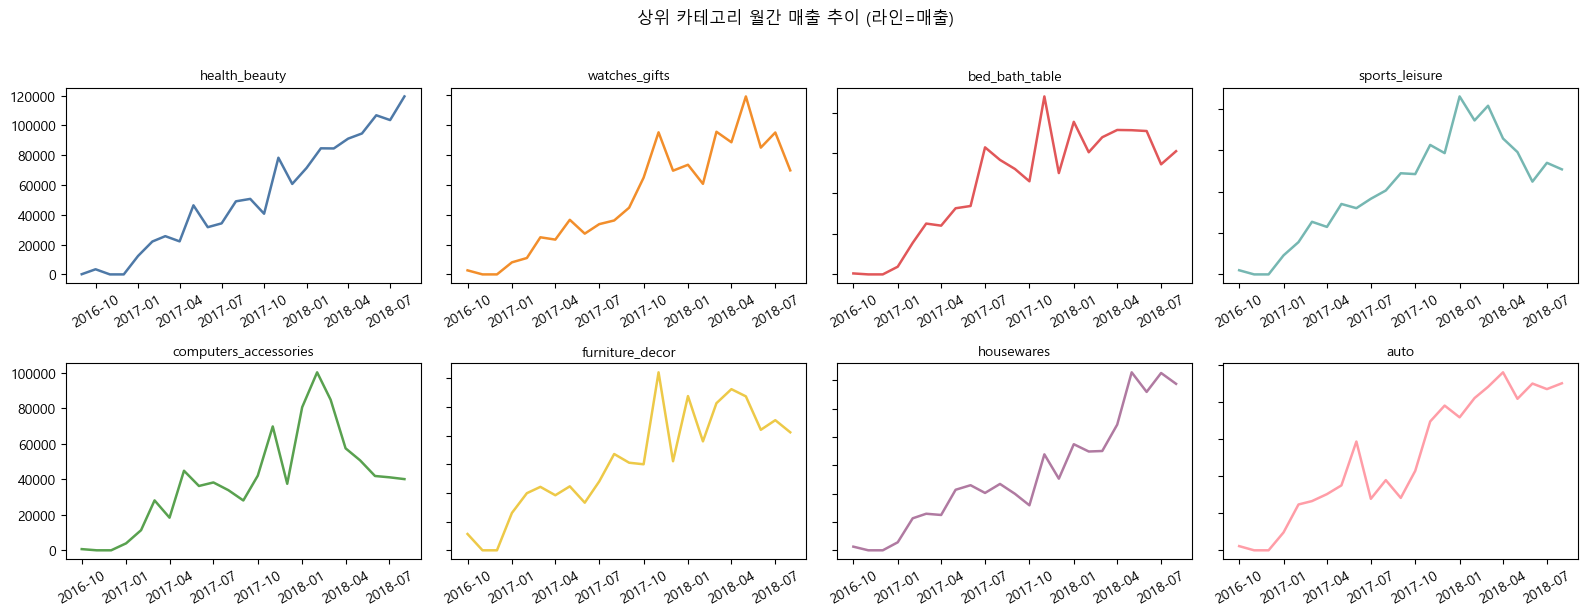

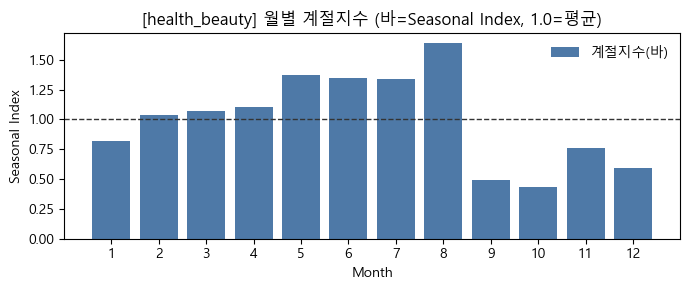

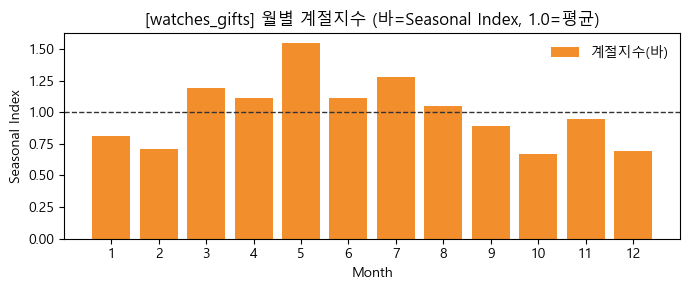

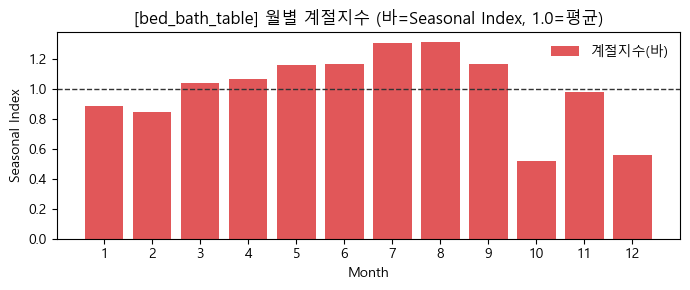

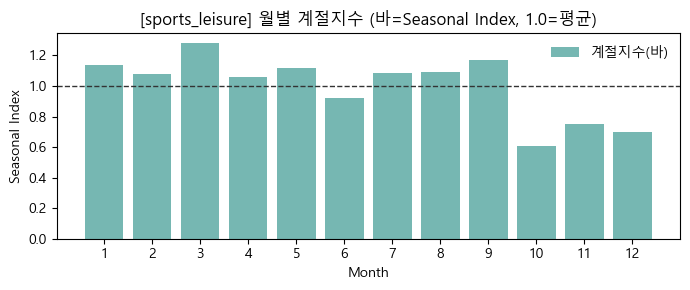

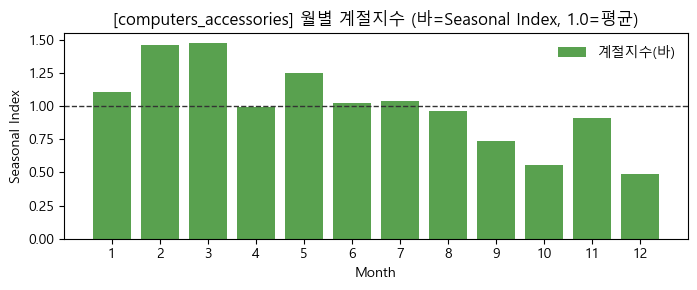

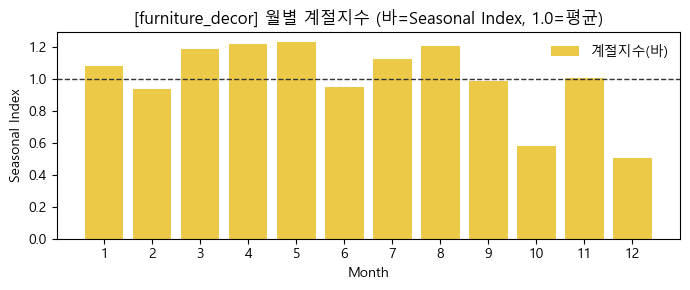

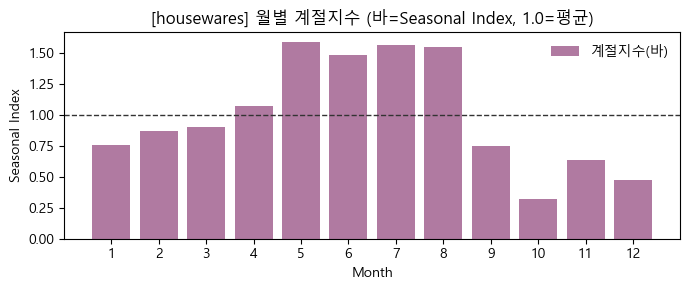

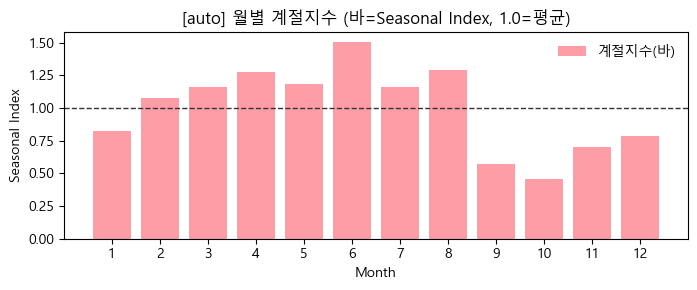

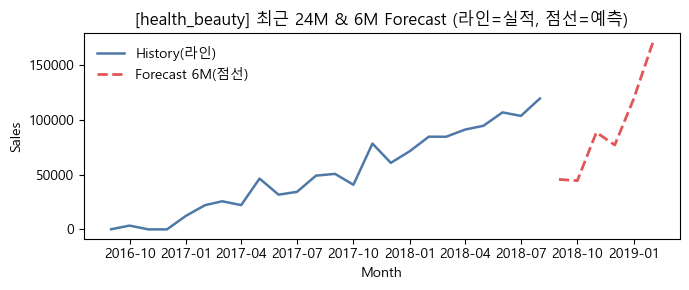

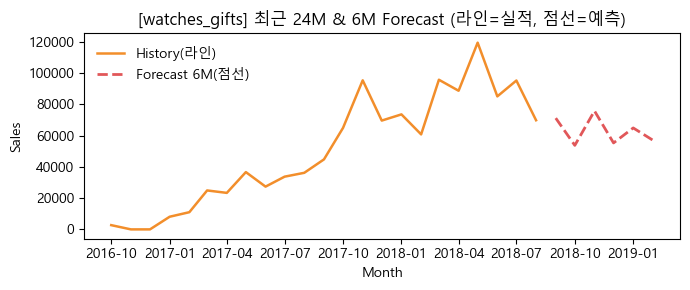

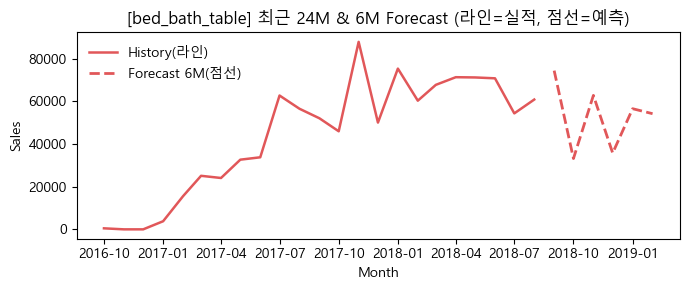

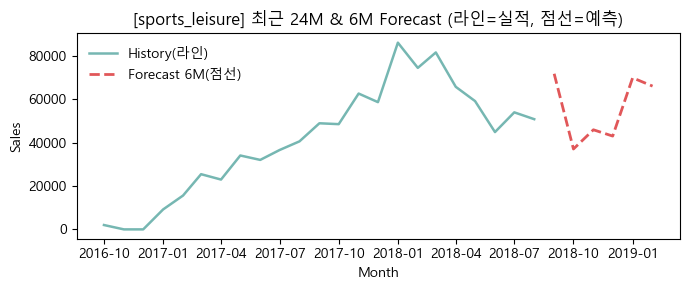

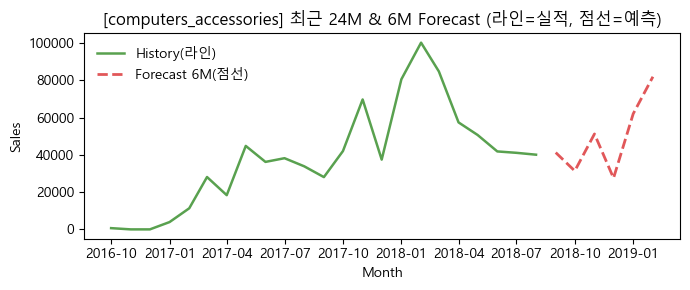

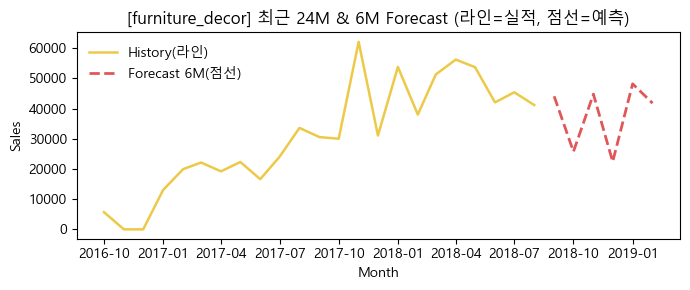

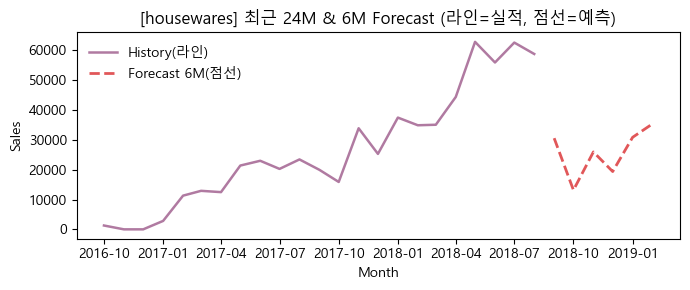

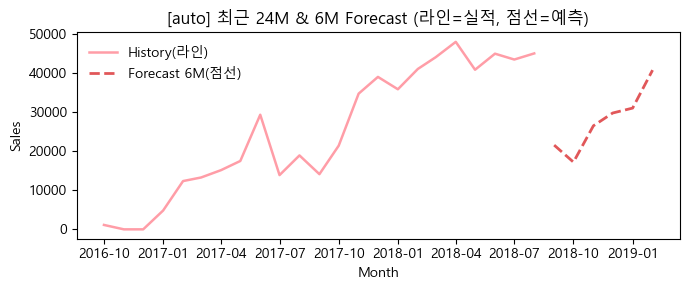

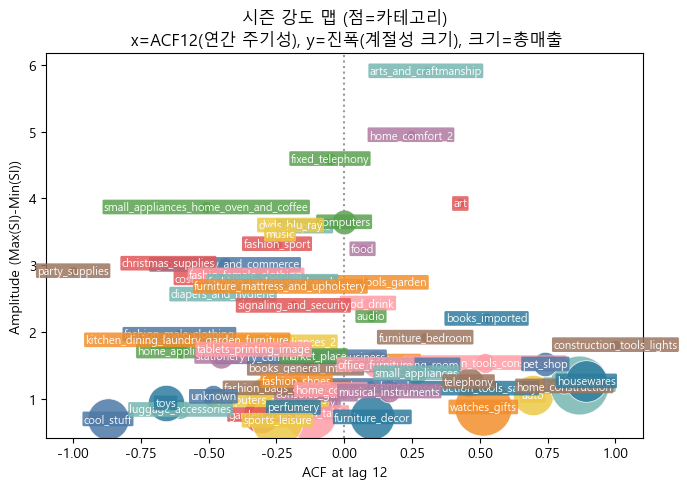

✅ 과제 3: 집계/계절성/예측/시각화 생성 완료 (오타 FIX 반영)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# =========================================================
# 과제 3: 카테고리별 월간 트렌드/계절성 분석 + 6M 예측 (오류수정 완전판)
# - FIX: plt.ylab 오타 → plt.ylabel 로 수정
# - 계절지수(SI) 12개월 고정, 결측월 0 채움
# 전제 DF: orders_clean, order_items_clean, products_clean, category_tr_clean
# (옵션) payments_clean
# =========================================================

# ---------- 가드 ----------
_need = {"orders_clean","order_items_clean","products_clean","category_tr_clean"}
_missing = [x for x in _need if x not in globals()]
if _missing:
    raise NameError(f"다음 DataFrame이 필요합니다: {_missing}")


# ---------- 1) 카테고리 영문명 보장 ----------
if "category_en" not in products_clean.columns:
    cat_map = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
    products_clean = products_clean.copy()
    products_clean["category_en"] = products_clean["product_category_name"].map(cat_map).fillna("unknown")

# ---------- 2) 카테고리×월 판매 집계 ----------
od = orders_clean.loc[orders_clean["order_status"]=="delivered",
                      ["order_id","order_purchase_timestamp"]].dropna()
od["order_month"] = od["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

oi = order_items_clean[["order_id","product_id","price"]].copy()
prod = products_clean[["product_id","category_en"]].copy()
oi = oi.merge(prod, on="product_id", how="left")
oi["category_en"] = oi["category_en"].fillna("unknown")

od_oi = od.merge(oi, on="order_id", how="inner")

# 기본 매출: price 합(배송비 제외)
cat_monthly = (od_oi.groupby(["category_en","order_month"])
                 .agg(sales=("price","sum"),
                      items=("product_id","count"),
                      orders=("order_id","nunique"))
                 .reset_index())

# ---------- 3) 결측 월 0 채움(카테고리별 월 범위 보정) ----------
def _complete_months(df_cat):
    idx = pd.date_range(df_cat["order_month"].min(), df_cat["order_month"].max(), freq="MS")
    out = df_cat.set_index("order_month").reindex(idx)
    out.index.name = "order_month"
    return out.reset_index()

filled = []
for cat, g in cat_monthly.groupby("category_en", sort=False):
    gg = _complete_months(g)
    gg["category_en"] = cat
    for col in ["sales","items","orders"]:
        gg[col] = gg[col].fillna(0.0)
    filled.append(gg)
cat_monthly_full = pd.concat(filled, ignore_index=True)

# ---------- 4) 계절지수/지표 (12개월 길이 보장) ----------
def seasonal_index_by_moy(series: pd.Series) -> np.ndarray:
    """
    월별 계절지수(1~12월) 배열을 항상 길이 12로 반환.
    - 결측 월은 1.0으로 채움(평균 수준).
    - 전체 평균이 0이면 12개 모두 1.0 반환.
    """
    s = series.copy().asfreq("MS", fill_value=0.0)
    moy = s.groupby(s.index.month).mean()             # 1..12월 평균
    overall = moy.mean()
    if overall == 0 or pd.isna(overall):
        return np.ones(12, dtype=float)
    si = (moy / overall).reindex(range(1,13)).fillna(1.0).to_numpy(dtype=float)
    if si.size != 12:  # 방어
        out = np.ones(12, dtype=float)
        n = min(12, si.size)
        out[:n] = si[:n]
        return out
    return si

def acf_at_lag(series: pd.Series, lag=12):
    x = series.asfreq("MS", fill_value=0.0).to_numpy(dtype=float)
    if len(x) <= lag or np.allclose(x.std(), 0):
        return np.nan
    x = x - x.mean()
    return float(np.corrcoef(x[lag:], x[:-lag])[0,1])

season_rows = []
for cat, g in cat_monthly_full.groupby("category_en", sort=False):
    s = g.set_index("order_month")["sales"].asfreq("MS", fill_value=0.0)
    if s.sum() == 0 or len(s) < 6:   # 너무 짧은 시계열은 스킵(원하면 12로 변경 가능)
        continue
    si_vec = seasonal_index_by_moy(s)                 # 길이 12 보장
    amp = float(si_vec.max() - si_vec.min())          # 계절 진폭
    cv  = float(s.std()/s.mean()) if s.mean() > 0 else np.nan  # 변동계수
    acf12 = acf_at_lag(s, 12)
    season_rows.append({
        "category_en": cat,
        "seasonal_index": si_vec.tolist(),            # 리스트(길이 12)
        "amp": amp, "cv": cv, "acf12": acf12,
        "total_sales": float(s.sum())
    })

seasonality = pd.DataFrame(season_rows)

# 월별 계절지수 컬럼(SI_01~SI_12)로 펼치기
si_cols = [f"SI_{m:02d}" for m in range(1,13)]
if not seasonality.empty:
    seasonality[si_cols] = pd.DataFrame(seasonality["seasonal_index"].tolist(),
                                        index=seasonality.index)
seasonality = seasonality.drop(columns=["seasonal_index"])

# ---------- 5) 우선순위 요약(시즌 강도/변동성/주기성) ----------
if not seasonality.empty:
    amp_norm = seasonality["amp"] / (seasonality["amp"].max() or 1)
    cv_norm  = seasonality["cv"]  / (seasonality["cv"].max()  or 1)
    acf_pos  = seasonality["acf12"].clip(lower=0)
    acf_norm = acf_pos / (acf_pos.max() or 1)

    summary = (seasonality
               .assign(
                    season_strength = seasonality["amp"].rank(ascending=False, method="dense"),
                    volatility     = seasonality["cv"].rank(ascending=False, method="dense"),
                    priority_score = 0.5*amp_norm + 0.3*cv_norm + 0.2*acf_norm
               )
               .sort_values("priority_score", ascending=False))
else:
    summary = pd.DataFrame(columns=["category_en","amp","cv","acf12","priority_score"])

print("=== [계절성 요약 상위 15] ===")
display(summary[["category_en","amp","cv","acf12","priority_score"]].head(15))

# ---------- 6) 상위 카테고리 선정(최근 12M 매출 기준) ----------
cutoff_date = cat_monthly_full["order_month"].max()
t12 = cutoff_date - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
mask_t12 = cat_monthly_full["order_month"] >= t12
top_cats = (cat_monthly_full.loc[mask_t12].groupby("category_en")["sales"].sum()
            .sort_values(ascending=False).head(8).index.tolist())

# ---------- 7) 간단 예측(6개월): 추세×계절지수 ----------
def forecast_next_6(series: pd.Series) -> pd.Series:
    """series: 월별 매출(≥6 추천)
       - 최근 12M 평균 = base
       - 성장률 g = (최근12합/그전12합)^(1/12)-1 (가능할 때)
       - 예측 = base*(1+g)^t * 계절지수(월)
    """
    s = series.asfreq("MS", fill_value=0.0)
    if len(s) < 6:
        return pd.Series(dtype=float)
    end = s.index.max()
    last12  = s.loc[end - pd.DateOffset(months=11): end]
    prev12s = s.loc[end - pd.DateOffset(months=23): end - pd.DateOffset(months=12)]
    base = last12.mean()
    if len(prev12s) == 12 and prev12s.sum() > 0:
        g = (last12.sum()/prev12s.sum())**(1/12) - 1
    else:
        g = 0.0
    si = seasonal_index_by_moy(s)  # 길이 12 보장
    future_idx = pd.date_range(end + pd.DateOffset(months=1), periods=6, freq="MS")
    f = []
    for i, dt in enumerate(future_idx, start=1):
        moy = dt.month
        fval = base * ((1+g)**i) * float(si[moy-1])
        f.append(fval)
    return pd.Series(f, index=future_idx)

# 카테고리별 예측 생성
fc_rows = []
for cat, g in cat_monthly_full.groupby("category_en", sort=False):
    s = g.set_index("order_month")["sales"]
    fc = forecast_next_6(s)
    if fc.empty: 
        continue
    for dt, val in fc.items():
        fc_rows.append({"category_en":cat, "order_month":dt, "forecast_sales":float(val)})
forecast_df = pd.DataFrame(fc_rows)

# ---------- 8) 시각화 ----------
colors = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
          "#EDC948","#B07AA1","#FF9DA7","#9C755F","#2E7C9E"]

# (A) 상위 카테고리 월간 매출 라인(스몰멀티플)
plot_cats = top_cats
n = len(plot_cats)
cols = 4
rows = (n + cols - 1)//cols if n>0 else 1
if n > 0:
    plt.figure(figsize=(4*cols, 3*rows))
    for i, cat in enumerate(plot_cats, start=1):
        ax = plt.subplot(rows, cols, i)
        s = (cat_monthly_full[cat_monthly_full["category_en"]==cat]
             .set_index("order_month")["sales"])
        ax.plot(s.index, s.values, linewidth=1.8, color=colors[(i-1)%len(colors)], label="월 매출(라인)")
        ax.set_title(cat, fontsize=10)
        ax.tick_params(axis='x', labelrotation=30)
        if i % cols != 1:
            ax.set_yticklabels([])
    plt.suptitle("상위 카테고리 월간 매출 추이 (라인=매출)", y=1.02)
    plt.tight_layout(); plt.show()

# (B) 상위 카테고리 월별 계절지수 바(12개월)  <-- FIX: ylabel 사용
if not seasonality.empty:
    for i, cat in enumerate(plot_cats, start=1):
        row = seasonality.loc[seasonality["category_en"]==cat]
        if row.empty:
            continue
        si_vals = row[si_cols].iloc[0].values
        plt.figure(figsize=(7,3))
        plt.bar(range(1,13), si_vals, color=colors[(i-1)%len(colors)], label="계절지수(바)")
        plt.axhline(1.0, linestyle="--", color="#333333", linewidth=1)
        plt.xticks(range(1,13))
        plt.title(f"[{cat}] 월별 계절지수 (바=Seasonal Index, 1.0=평균)")
        plt.xlabel("Month"); plt.ylabel("Seasonal Index")  # ← 여기 수정
        plt.legend(frameon=False)
        plt.tight_layout(); plt.show()

# (C) 상위 카테고리 예측(최근 24개월 + 6개월 Forecast)
if n > 0:
    for i, cat in enumerate(plot_cats, start=1):
        g = cat_monthly_full[cat_monthly_full["category_en"]==cat]
        s = g.set_index("order_month")["sales"].asfreq("MS", fill_value=0.0)
        start = max(s.index.min(), s.index.max() - pd.DateOffset(months=24) + pd.offsets.MonthBegin(0))
        hist = s.loc[start:]
        fc = forecast_df[forecast_df["category_en"]==cat].set_index("order_month")["forecast_sales"]
        plt.figure(figsize=(7,3))
        plt.plot(hist.index, hist.values, label="History(라인)", color=colors[(i-1)%len(colors)], linewidth=1.8)
        if not fc.empty:
            plt.plot(fc.index, fc.values, label="Forecast 6M(점선)", color="#E15759", linestyle="--", linewidth=2)
        plt.title(f"[{cat}] 최근 24M & 6M Forecast (라인=실적, 점선=예측)")
        plt.xlabel("Month"); plt.ylabel("Sales")
        plt.legend(frameon=False)
        plt.tight_layout(); plt.show()

# (D) 시즌 강도 vs 변동성 vs 규모 (우선순위 맵)
if not seasonality.empty:
    ss = seasonality.copy()
    ss = ss.merge(cat_monthly_full.groupby("category_en")["sales"].sum().rename("total_sales_all"),
                  on="category_en", how="left")
    plt.figure(figsize=(7,5))
    sizes = (ss["total_sales_all"]/ss["total_sales_all"].max()*1800).clip(50,1800).values
    for i, r in ss.iterrows():
        c = colors[i % len(colors)]
        plt.scatter(r["acf12"], r["amp"], s=sizes[i], color=c, alpha=0.85, edgecolor="white", linewidth=0.6)
        plt.text(r["acf12"], r["amp"], r["category_en"], ha="center", va="center", fontsize=8, color="white",
                 bbox=dict(boxstyle="round,pad=0.12", fc=c, ec="none", alpha=0.85))
    plt.axvline(0, color="#999999", linestyle=":")
    plt.title("시즌 강도 맵 (점=카테고리)\n x=ACF12(연간 주기성), y=진폭(계절성 크기), 크기=총매출")
    plt.xlabel("ACF at lag 12"); plt.ylabel("Amplitude (Max(SI)-Min(SI))")
    plt.tight_layout(); plt.show()

print("✅ 과제 3: 집계/계절성/예측/시각화 생성 완료 (오타 FIX 반영)")


=== [계절성 요약 상위 15] ===


c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,category_en,amp,cv,acf12,priority_score
3,arts_and_craftmanship,5.913180,2.346521,0.300782,0.860156
46,home_comfort_2,4.955293,1.911616,0.245927,0.712587
2,art,3.924501,1.281999,0.427972,0.581340
34,fixed_telephony,4.598040,1.327212,-0.052828,0.558478
64,small_appliances_home_oven_and_coffee,3.872122,1.356141,-0.509125,0.500795
25,dvds_blu_ray,3.601443,1.505742,-0.198252,0.497034
13,cine_photo,3.585038,1.500260,-0.147683,0.494946
55,music,3.461825,1.519021,-0.237092,0.486926
14,computers,3.650342,1.326105,-0.000602,0.478202
18,construction_tools_lights,1.809054,0.926837,1.000000,0.471463


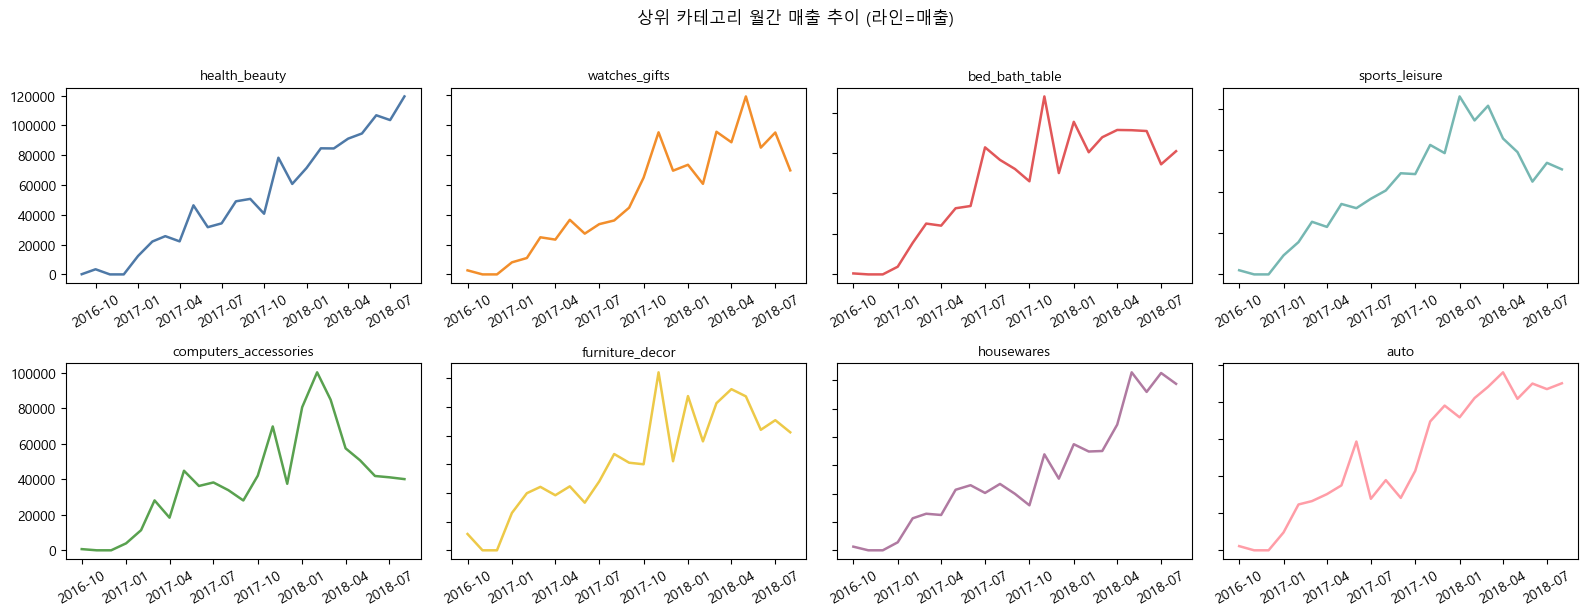

AttributeError: module 'matplotlib.pyplot' has no attribute 'ylab'

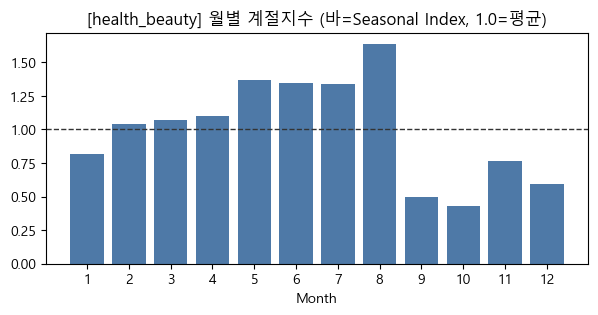

In [ ]:


# =========================================================
# 과제 3: 카테고리별 월간 트렌드/계절성 분석 + 6M 예측 (패치 통합판)
# 전제: orders_clean, order_items_clean, products_clean, category_tr_clean 가 메모리에 존재
# 선택: payments_clean (결제액 분배 매출 산정 사용 시)
# =========================================================

# ---------- 가드 ----------
_need = {"orders_clean","order_items_clean","products_clean","category_tr_clean"}
_missing = [x for x in _need if x not in globals()]
if _missing:
    raise NameError(f"다음 DataFrame이 필요합니다: {_missing}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1) 카테고리 영문명 보장 ----------
if "category_en" not in products_clean.columns:
    cat_map = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
    products_clean = products_clean.copy()
    products_clean["category_en"] = products_clean["product_category_name"].map(cat_map).fillna("unknown")

# ---------- 2) 카테고리×월 판매 집계 ----------
# 기준: 구매일(order_purchase_timestamp) 기준 월(MS)
od = orders_clean.loc[orders_clean["order_status"]=="delivered",
                      ["order_id","order_purchase_timestamp"]].dropna()
od["order_month"] = od["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

oi = order_items_clean[["order_id","product_id","price"]].copy()
prod = products_clean[["product_id","category_en"]].copy()
oi = oi.merge(prod, on="product_id", how="left")
oi["category_en"] = oi["category_en"].fillna("unknown")

od_oi = od.merge(oi, on="order_id", how="inner")

# 기본 매출: price 합(배송비 제외)
cat_monthly = (od_oi.groupby(["category_en","order_month"])
                 .agg(sales=("price","sum"),
                      items=("product_id","count"),
                      orders=("order_id","nunique"))
                 .reset_index())

# (선택) 결제액 분배 방식으로 매출 재계산 — 필요 시 주석 해제
# if "payments_clean" in globals():
#     pay_per_order = payments_clean.groupby("order_id")["payment_value"].sum()
#     base = oi.merge(od[["order_id","order_month"]], on="order_id", how="inner")
#     order_sum = base.groupby("order_id")["price"].sum().rename("sum_price")
#     base = base.merge(order_sum, on="order_id", how="left")
#     base["share"] = np.where(base["sum_price"]>0, base["price"]/base["sum_price"], 0)
#     base = base.merge(pay_per_order.rename("pay_sum"), left_on="order_id", right_index=True, how="left")
#     base["rev_alloc"] = base["share"]*base["pay_sum"]
#     base = base.merge(prod, on="product_id", how="left")
#     cat_monthly = (base.groupby(["category_en","order_month"])
#                        .agg(sales=("rev_alloc","sum"), items=("product_id","count"), orders=("order_id","nunique"))
#                        .reset_index())

# ---------- 3) 결측 월 0 채움(카테고리별 월 범위 보정) ----------
def _complete_months(df_cat):
    idx = pd.date_range(df_cat["order_month"].min(), df_cat["order_month"].max(), freq="MS")
    out = df_cat.set_index("order_month").reindex(idx)
    out.index.name = "order_month"
    return out.reset_index()

filled = []
for cat, g in cat_monthly.groupby("category_en", sort=False):
    gg = _complete_months(g)
    gg["category_en"] = cat
    for col in ["sales","items","orders"]:
        gg[col] = gg[col].fillna(0.0)
    filled.append(gg)
cat_monthly_full = pd.concat(filled, ignore_index=True)

# ---------- 4) 계절지수/지표 (12개월 길이 보장 패치) ----------
def seasonal_index_by_moy(series: pd.Series) -> np.ndarray:
    """
    월별 계절지수(1~12월) 배열을 항상 길이 12로 반환.
    - 결측 월은 1.0으로 채움(평균 수준).
    - 전체 평균이 0이면 12개 모두 1.0 반환.
    """
    s = series.copy().asfreq("MS", fill_value=0.0)
    moy = s.groupby(s.index.month).mean()             # 1..12월 평균
    overall = moy.mean()
    if overall == 0 or pd.isna(overall):
        return np.ones(12, dtype=float)
    si = (moy / overall).reindex(range(1,13)).fillna(1.0).to_numpy(dtype=float)
    if si.size != 12:  # 방어
        out = np.ones(12, dtype=float)
        n = min(12, si.size)
        out[:n] = si[:n]
        return out
    return si

def acf_at_lag(series: pd.Series, lag=12):
    x = series.asfreq("MS", fill_value=0.0).to_numpy(dtype=float)
    if len(x) <= lag or np.allclose(x.std(), 0):
        return np.nan
    x = x - x.mean()
    return float(np.corrcoef(x[lag:], x[:-lag])[0,1])

season_rows = []
for cat, g in cat_monthly_full.groupby("category_en", sort=False):
    s = g.set_index("order_month")["sales"].asfreq("MS", fill_value=0.0)
    if s.sum() == 0 or len(s) < 6:   # 너무 짧은 시계열은 스킵(원하면 12로 변경 가능)
        continue
    si_vec = seasonal_index_by_moy(s)                 # 길이 12 보장
    amp = float(si_vec.max() - si_vec.min())          # 계절 진폭
    cv  = float(s.std()/s.mean()) if s.mean() > 0 else np.nan  # 변동계수
    acf12 = acf_at_lag(s, 12)
    season_rows.append({
        "category_en": cat,
        "seasonal_index": si_vec.tolist(),            # 리스트(길이 12)
        "amp": amp, "cv": cv, "acf12": acf12,
        "total_sales": float(s.sum())
    })

seasonality = pd.DataFrame(season_rows)

# 월별 계절지수 컬럼(SI_01~SI_12)로 펼치기
si_cols = [f"SI_{m:02d}" for m in range(1,13)]
if not seasonality.empty:
    seasonality[si_cols] = pd.DataFrame(seasonality["seasonal_index"].tolist(),
                                        index=seasonality.index)
seasonality = seasonality.drop(columns=["seasonal_index"])

# ---------- 5) 우선순위 요약(시즌 강도/변동성/주기성) ----------
if not seasonality.empty:
    # 안전한 정규화(분모 0 방지)
    amp_norm = seasonality["amp"] / (seasonality["amp"].max() or 1)
    cv_norm  = seasonality["cv"]  / (seasonality["cv"].max()  or 1)
    acf_pos  = seasonality["acf12"].clip(lower=0)
    acf_norm = acf_pos / (acf_pos.max() or 1)

    summary = (seasonality
               .assign(
                    season_strength = seasonality["amp"].rank(ascending=False, method="dense"),
                    volatility     = seasonality["cv"].rank(ascending=False, method="dense"),
                    priority_score = 0.5*amp_norm + 0.3*cv_norm + 0.2*acf_norm
               )
               .sort_values("priority_score", ascending=False))
else:
    summary = pd.DataFrame(columns=["category_en","amp","cv","acf12","priority_score"])

print("=== [계절성 요약 상위 15] ===")
display(summary[["category_en","amp","cv","acf12","priority_score"]].head(15))

# ---------- 6) 상위 카테고리 선정(최근 12M 매출 기준) ----------
cutoff_date = cat_monthly_full["order_month"].max()
t12 = cutoff_date - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
mask_t12 = cat_monthly_full["order_month"] >= t12
top_cats = (cat_monthly_full.loc[mask_t12].groupby("category_en")["sales"].sum()
            .sort_values(ascending=False).head(8).index.tolist())

# ---------- 7) 간단 예측(6개월): 추세×계절지수 ----------
def forecast_next_6(series: pd.Series) -> pd.Series:
    """series: 월별 매출(≥6 추천)
       - 최근 12M 평균 = base
       - 성장률 g = (최근12합/그전12합)^(1/12)-1 (가능할 때)
       - 예측 = base*(1+g)^t * 계절지수(월)
    """
    s = series.asfreq("MS", fill_value=0.0)
    if len(s) < 6:
        return pd.Series(dtype=float)
    end = s.index.max()
    last12  = s.loc[end - pd.DateOffset(months=11): end]
    prev12s = s.loc[end - pd.DateOffset(months=23): end - pd.DateOffset(months=12)]
    base = last12.mean()
    if len(prev12s) == 12 and prev12s.sum() > 0:
        g = (last12.sum()/prev12s.sum())**(1/12) - 1
    else:
        g = 0.0
    si = seasonal_index_by_moy(s)  # 길이 12 보장
    future_idx = pd.date_range(end + pd.DateOffset(months=1), periods=6, freq="MS")
    f = []
    for i, dt in enumerate(future_idx, start=1):
        moy = dt.month
        fval = base * ((1+g)**i) * float(si[moy-1])
        f.append(fval)
    return pd.Series(f, index=future_idx)

# 카테고리별 예측 생성
fc_rows = []
for cat, g in cat_monthly_full.groupby("category_en", sort=False):
    s = g.set_index("order_month")["sales"]
    fc = forecast_next_6(s)
    if fc.empty: 
        continue
    for dt, val in fc.items():
        fc_rows.append({"category_en":cat, "order_month":dt, "forecast_sales":float(val)})
forecast_df = pd.DataFrame(fc_rows)

# ---------- 8) 시각화 ----------
colors = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
          "#EDC948","#B07AA1","#FF9DA7","#9C755F","#2E7C9E"]

# (A) 상위 카테고리 월간 매출 라인(스몰멀티플)
plot_cats = top_cats
n = len(plot_cats)
cols = 4
rows = (n + cols - 1)//cols if n>0 else 1
if n > 0:
    plt.figure(figsize=(4*cols, 3*rows))
    for i, cat in enumerate(plot_cats, start=1):
        ax = plt.subplot(rows, cols, i)
        s = (cat_monthly_full[cat_monthly_full["category_en"]==cat]
             .set_index("order_month")["sales"])
        ax.plot(s.index, s.values, linewidth=1.8, color=colors[(i-1)%len(colors)], label="월 매출(라인)")
        ax.set_title(cat, fontsize=10)
        ax.tick_params(axis='x', labelrotation=30)
        if i % cols != 1:
            ax.set_yticklabels([])
    plt.suptitle("상위 카테고리 월간 매출 추이 (라인=매출)", y=1.02)
    plt.tight_layout(); plt.show()

# (B) 상위 카테고리 월별 계절지수 바(12개월)
if not seasonality.empty:
    for i, cat in enumerate(plot_cats, start=1):
        row = seasonality.loc[seasonality["category_en"]==cat]
        if row.empty:
            continue
        si_vals = row[si_cols].iloc[0].values
        plt.figure(figsize=(7,3))
        plt.bar(range(1,13), si_vals, color=colors[(i-1)%len(colors)], label="계절지수(바)")
        plt.axhline(1.0, linestyle="--", color="#333333", linewidth=1)
        plt.xticks(range(1,13))
        plt.title(f"[{cat}] 월별 계절지수 (바=Seasonal Index, 1.0=평균)")
        plt.xlabel("Month"); plt.ylab


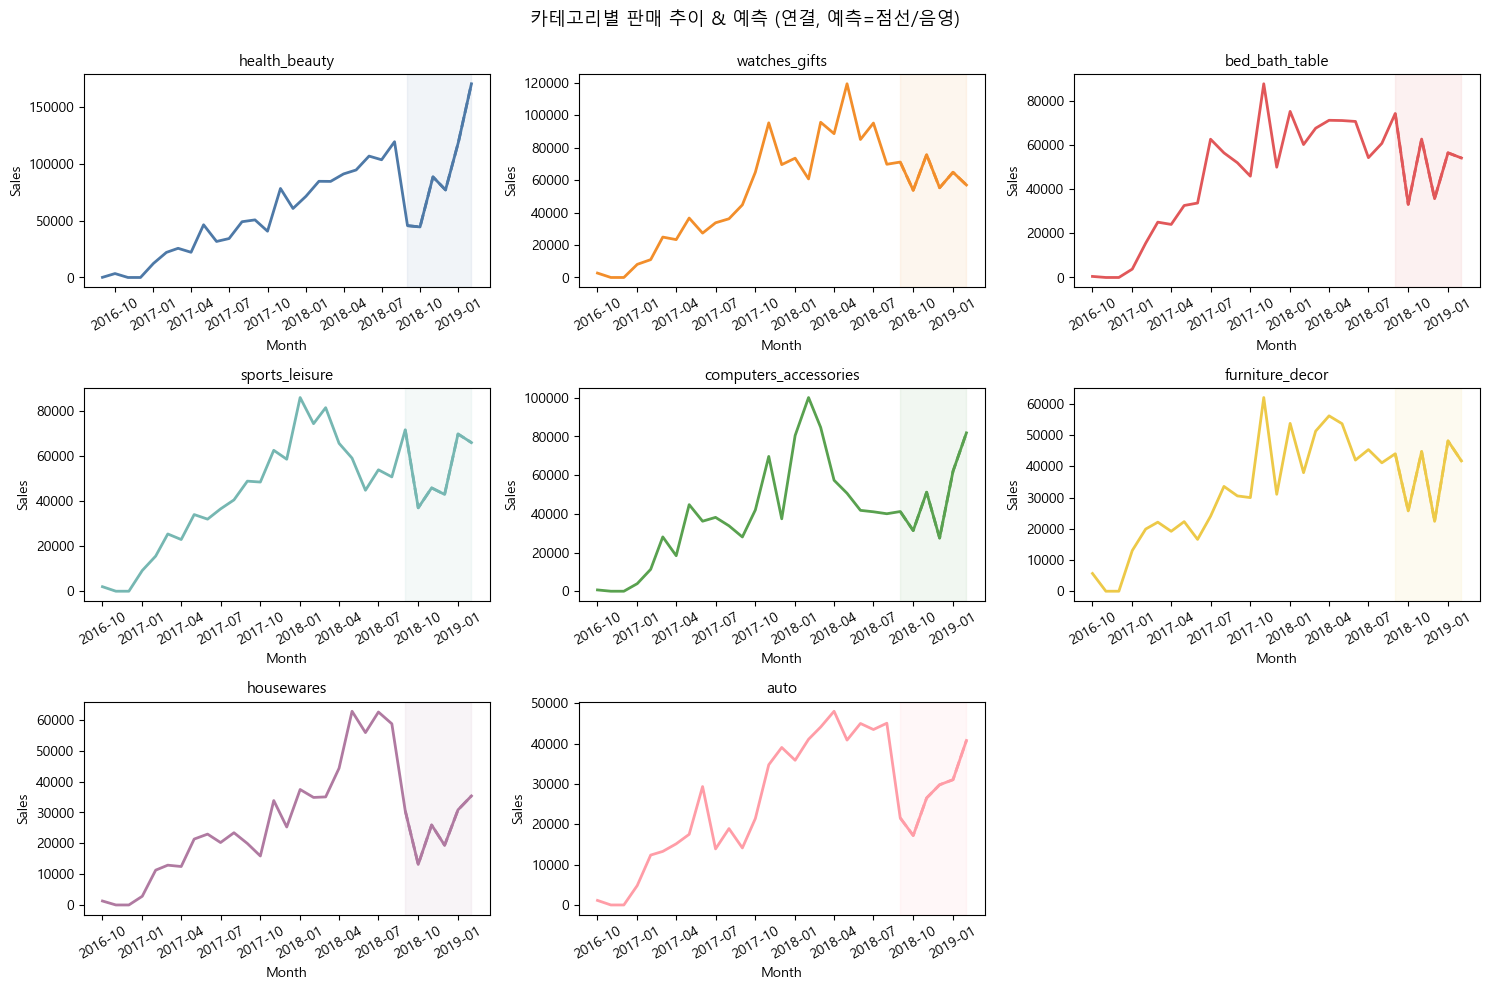

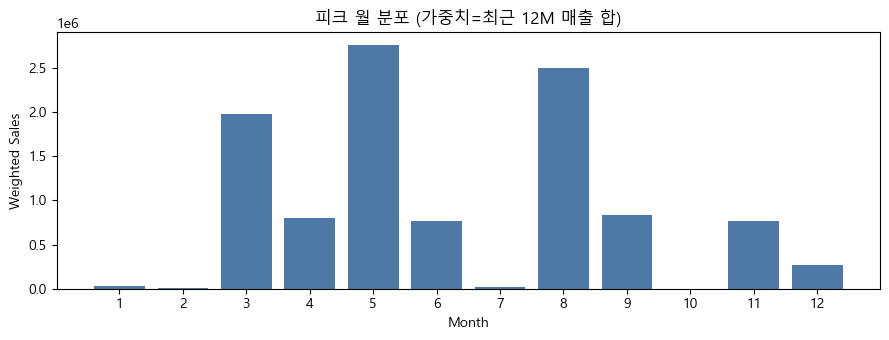

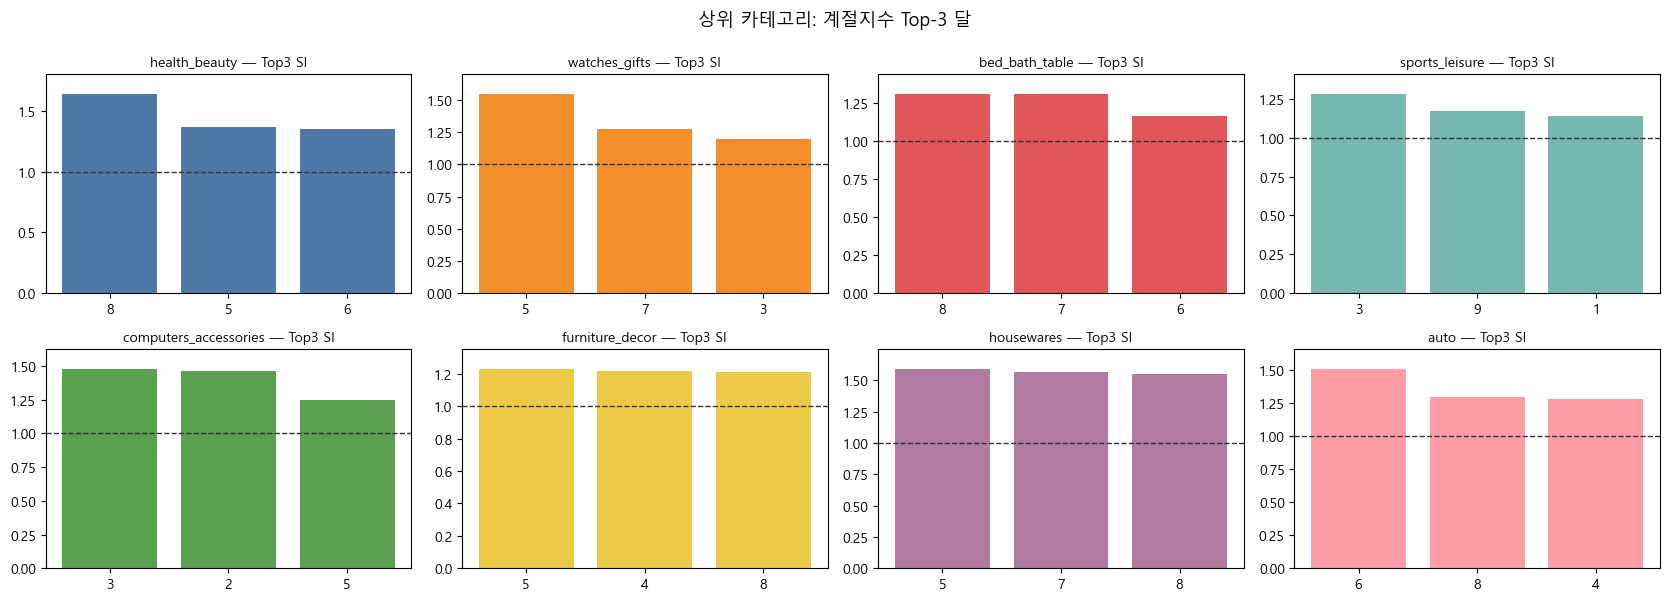

=== 재고전략 표(상위 카테고리 우선) — z=1.65 기준 ===


,Category,월평균수요,월표준편차,평균리드타임(일),안전재고,재주문점(ROP)
43,health_beauty,79620.46,24166.20,12.0,25196.69,56989.34
71,watches_gifts,76807.62,22813.56,12.7,24456.14,56877.09
15,computers_accessories,54403.91,22453.23,13.2,24598.29,48581.90
7,bed_bath_table,63468.58,11895.19,12.8,12823.58,39917.19
65,sports_leisure,59749.30,14089.76,12.1,14794.56,38991.59
49,housewares,39248.84,16375.31,10.9,16303.28,30593.20
39,furniture_decor,43767.27,10883.04,12.9,11766.18,30557.30
5,auto,36270.27,11061.25,12.2,11651.23,26432.71


✅ 보강 완료: 자연스러운 예측 서브플롯 + 시즌 대체 시각화 + 재고전략 표


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# =========================================================
# 과제 3 보강: 자연스러운 예측 시각화(서브플롯) + 시즌 대체 시각화 + 재고전략 표
# =========================================================

# ---------- 안전 체크 & 필요 산출물 보장 ----------
_need_base = {"orders_clean","order_items_clean","products_clean","category_tr_clean"}
_missing = [x for x in _need_base if x not in globals()]
if _missing:
    raise NameError(f"다음 DF가 필요합니다: {_missing}")

# 카테고리 영문명 보장
if "category_en" not in products_clean.columns:
    cat_map = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
    products_clean = products_clean.copy()
    products_clean["category_en"] = products_clean["product_category_name"].map(cat_map).fillna("unknown")

# 색상 팔레트
colors = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
          "#EDC948","#B07AA1","#FF9DA7","#9C755F","#2E7C9E"]

# ---------- cat_monthly_full 보장 ----------
if "cat_monthly_full" not in globals():
    od = orders_clean.loc[orders_clean["order_status"]=="delivered",
                          ["order_id","order_purchase_timestamp"]].dropna()
    od["order_month"] = od["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

    oi = order_items_clean[["order_id","product_id","price"]].copy()
    prod = products_clean[["product_id","category_en"]].copy()
    oi = oi.merge(prod, on="product_id", how="left")
    oi["category_en"] = oi["category_en"].fillna("unknown")

    od_oi = od.merge(oi, on="order_id", how="inner")
    cat_monthly = (od_oi.groupby(["category_en","order_month"])
                     .agg(sales=("price","sum"),
                          items=("product_id","count"),
                          orders=("order_id","nunique"))
                     .reset_index())

    def _complete_months(df_cat):
        idx = pd.date_range(df_cat["order_month"].min(), df_cat["order_month"].max(), freq="MS")
        out = df_cat.set_index("order_month").reindex(idx)
        out.index.name = "order_month"
        return out.reset_index()

    filled = []
    for cat, g in cat_monthly.groupby("category_en", sort=False):
        gg = _complete_months(g)
        gg["category_en"] = cat
        for col in ["sales","items","orders"]:
            gg[col] = gg[col].fillna(0.0)
        filled.append(gg)
    cat_monthly_full = pd.concat(filled, ignore_index=True)

# ---------- seasonality/summary 보장 ----------
def _seasonal_index_by_moy(series: pd.Series) -> np.ndarray:
    s = series.copy().asfreq("MS", fill_value=0.0)
    moy = s.groupby(s.index.month).mean()
    overall = moy.mean()
    if overall == 0 or pd.isna(overall):
        return np.ones(12, dtype=float)
    si = (moy / overall).reindex(range(1,13)).fillna(1.0).to_numpy(dtype=float)
    if si.size != 12:
        out = np.ones(12, dtype=float)
        n = min(12, si.size)
        out[:n] = si[:n]
        return out
    return si

def _acf_at_lag(series: pd.Series, lag=12):
    x = series.asfreq("MS", fill_value=0.0).to_numpy(dtype=float)
    if len(x) <= lag or np.allclose(x.std(), 0):
        return np.nan
    x = x - x.mean()
    return float(np.corrcoef(x[lag:], x[:-lag])[0,1])

if "seasonality" not in globals():
    season_rows = []
    for cat, g in cat_monthly_full.groupby("category_en", sort=False):
        s = g.set_index("order_month")["sales"].asfreq("MS", fill_value=0.0)
        if s.sum() == 0 or len(s) < 6:
            continue
        si_vec = _seasonal_index_by_moy(s)
        amp = float(si_vec.max() - si_vec.min())
        cv  = float(s.std()/s.mean()) if s.mean() > 0 else np.nan
        acf12 = _acf_at_lag(s, 12)
        season_rows.append({
            "category_en": cat, "seasonal_index": si_vec.tolist(),
            "amp": amp, "cv": cv, "acf12": acf12,
            "total_sales": float(s.sum())
        })
    seasonality = pd.DataFrame(season_rows)
    si_cols = [f"SI_{m:02d}" for m in range(1,13)]
    if not seasonality.empty:
        seasonality[si_cols] = pd.DataFrame(seasonality["seasonal_index"].tolist(),
                                            index=seasonality.index)
        seasonality = seasonality.drop(columns=["seasonal_index"])

    if not seasonality.empty:
        amp_norm = seasonality["amp"] / (seasonality["amp"].max() or 1)
        cv_norm  = seasonality["cv"]  / (seasonality["cv"].max()  or 1)
        acf_pos  = seasonality["acf12"].clip(lower=0)
        acf_norm = acf_pos / (acf_pos.max() or 1)
        summary = (seasonality
                   .assign(priority_score=0.5*amp_norm + 0.3*cv_norm + 0.2*acf_norm)
                   .sort_values("priority_score", ascending=False))
    else:
        summary = pd.DataFrame(columns=["category_en","amp","cv","acf12","priority_score"])
else:
    si_cols = [f"SI_{m:02d}" for m in range(1,13)]
    if "priority_score" not in seasonality.columns:
        amp_norm = seasonality["amp"] / (seasonality["amp"].max() or 1)
        cv_norm  = seasonality["cv"]  / (seasonality["cv"].max()  or 1)
        acf_pos  = seasonality["acf12"].clip(lower=0)
        acf_norm = acf_pos / (acf_pos.max() or 1)
        summary = (seasonality
                   .assign(priority_score=0.5*amp_norm + 0.3*cv_norm + 0.2*acf_norm)
                   .sort_values("priority_score", ascending=False))
    else:
        summary = seasonality.sort_values("priority_score", ascending=False)

# ---------- top_cats 보장(최근 12M 매출 기준) ----------
if "top_cats" not in globals():
    cutoff_date = cat_monthly_full["order_month"].max()
    t12 = cutoff_date - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
    mask_t12 = cat_monthly_full["order_month"] >= t12
    top_cats = (cat_monthly_full.loc[mask_t12].groupby("category_en")["sales"].sum()
                .sort_values(ascending=False).head(8).index.tolist())

# ---------- forecast_df 보장 ----------
def _forecast_next_6(series: pd.Series) -> pd.Series:
    s = series.asfreq("MS", fill_value=0.0)
    if len(s) < 6:
        return pd.Series(dtype=float)
    end = s.index.max()
    last12  = s.loc[end - pd.DateOffset(months=11): end]
    prev12s = s.loc[end - pd.DateOffset(months=23): end - pd.DateOffset(months=12)]
    base = last12.mean()
    if len(prev12s) == 12 and prev12s.sum() > 0:
        g = (last12.sum()/prev12s.sum())**(1/12) - 1
    else:
        g = 0.0
    si = _seasonal_index_by_moy(s)
    future_idx = pd.date_range(end + pd.DateOffset(months=1), periods=6, freq="MS")
    f = []
    for i, dt in enumerate(future_idx, start=1):
        moy = dt.month
        fval = base * ((1+g)**i) * float(si[moy-1])
        f.append(fval)
    return pd.Series(f, index=future_idx)

if "forecast_df" not in globals():
    fc_rows = []
    for cat, g in cat_monthly_full.groupby("category_en", sort=False):
        s = g.set_index("order_month")["sales"]
        fc = _forecast_next_6(s)
        if fc.empty: 
            continue
        for dt, val in fc.items():
            fc_rows.append({"category_en":cat, "order_month":dt, "forecast_sales":float(val)})
    forecast_df = pd.DataFrame(fc_rows)

# =========================================================
# (1) 자연스러운 예측 시각화: 서브플롯(히스토리+예측 한 줄, 예측 구간 점선/음영)
# =========================================================
plot_cats = top_cats
n = len(plot_cats)
if n > 0:
    cols = 3
    rows = (n + cols - 1)//cols
    fig = plt.figure(figsize=(5*cols, 3.3*rows))
    for i, cat in enumerate(plot_cats, start=1):
        ax = fig.add_subplot(rows, cols, i)
        g = cat_monthly_full[cat_monthly_full["category_en"]==cat]
        s = g.set_index("order_month")["sales"].asfreq("MS", fill_value=0.0)

        # 최근 24개월부터 표시
        start = max(s.index.min(), s.index.max() - pd.DateOffset(months=24) + pd.offsets.MonthBegin(0))
        hist = s.loc[start:]
        fc = forecast_df[forecast_df["category_en"]==cat].set_index("order_month")["forecast_sales"]

        # 히스토리 + 예측을 하나로 이어 붙인 시리즈
        comb = pd.concat([hist, fc]) if not fc.empty else hist.copy()

        # 전체 라인(연결), 색상 통일
        c = colors[(i-1) % len(colors)]
        ax.plot(comb.index, comb.values, color=c, linewidth=2)

        # 예측 구간만 점선으로 덮어 그려서 구분
        if not fc.empty:
            ax.plot(fc.index, fc.values, color=c, linewidth=2, linestyle="--", label="Forecast")
            # 예측 영역 음영
            ax.axvspan(fc.index.min(), fc.index.max(), color=c, alpha=0.08)

        ax.set_title(cat, fontsize=11)
        ax.set_xlabel("Month"); ax.set_ylabel("Sales")
        ax.tick_params(axis="x", labelrotation=30)
    fig.suptitle("카테고리별 판매 추이 & 예측 (연결, 예측=점선/음영)", y=0.995, fontsize=13)
    fig.tight_layout()
    plt.show()

# =========================================================
# (2) 시즌 강도 시각화 대체안
#   A) 피크 월 분포(가중치=최근 12M 매출)
#   B) 상위 카테고리 Top-3 시즌 달 미니 바차트
# =========================================================

# A) 피크 월 분포 (가중치=최근 12M 매출)
if not seasonality.empty:
    # 카테고리별 피크월
    si_mat = seasonality.set_index("category_en")[si_cols].copy()
    # 피크월(1~12)
    peak_month = si_mat.apply(lambda r: int(np.argmax(r.values))+1, axis=1)

    # 최근 12M 매출 가중치
    cutoff_date = cat_monthly_full["order_month"].max()
    t12 = cutoff_date - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
    w = (cat_monthly_full[cat_monthly_full["order_month"]>=t12]
         .groupby("category_en")["sales"].sum())
    peak_df = pd.DataFrame({"peak_month": peak_month}).merge(
        w.rename("weight"), left_index=True, right_index=True, how="left"
    ).fillna(0)

    weight_by_month = peak_df.groupby("peak_month")["weight"].sum().reindex(range(1,13)).fillna(0)

    plt.figure(figsize=(9,3.5))
    plt.bar(range(1,13), weight_by_month.values, color=colors[0])
    plt.title("피크 월 분포 (가중치=최근 12M 매출 합)")
    plt.xlabel("Month"); plt.ylabel("Weighted Sales")
    plt.xticks(range(1,13))
    plt.tight_layout(); plt.show()

# B) 상위 카테고리 Top-3 시즌 달 미니 바차트
if not seasonality.empty and len(top_cats) > 0:
    cols = 4
    rows = (len(top_cats) + cols - 1)//cols
    fig = plt.figure(figsize=(4.2*cols, 3*rows))
    for i, cat in enumerate(top_cats, start=1):
        ax = fig.add_subplot(rows, cols, i)
        row = seasonality.loc[seasonality["category_en"]==cat]
        if row.empty:
            ax.set_axis_off(); continue
        si_vals = row[si_cols].iloc[0].values
        top3_idx = np.argsort(si_vals)[-3:][::-1]  # 상위 3개월
        months = [int(m+1) for m in top3_idx]
        vals = si_vals[top3_idx]
        ax.bar([str(m) for m in months], vals, color=colors[(i-1)%len(colors)])
        ax.axhline(1.0, linestyle="--", color="#333333", linewidth=1)
        ax.set_title(f"{cat} — Top3 SI", fontsize=10)
        ax.set_ylim(0, max(1.2, vals.max()*1.1))
    fig.suptitle("상위 카테고리: 계절지수 Top-3 달", y=0.995, fontsize=13)
    fig.tight_layout()
    plt.show()

# =========================================================
# (3) 재고관리 전략 표: ROP & 안전재고 (최근 12M 수요 + 평균 리드타임)
#   - ROP = μ_daily * LT_days + z * σ_daily * sqrt(LT_days)
#   - 안전재고 = z * σ_daily * sqrt(LT_days)
#   - z: 서비스레벨(예: 95%) → z = 1.65 (변경 가능)
#   - 월→일 환산 근사: μ_daily = mean(monthly)/30, σ_daily ≈ std(monthly)/sqrt(30)
#     (일별 수요 데이터가 없을 때의 실무적 근사치)
# =========================================================

z = 1.65  # 95% 서비스레벨 기본값, 필요시 조정

# 카테고리별 평균 리드타임(일) 추정: 주문아이템→주문 리드타임 매핑
o = orders_clean.loc[orders_clean["order_status"]=="delivered",
                     ["order_id","order_purchase_timestamp","order_delivered_customer_date"]].dropna()
o["lead_days"] = (o["order_delivered_customer_date"] - o["order_purchase_timestamp"]).dt.total_seconds()/86400

oi = order_items_clean[["order_id","product_id"]].copy()
prod = products_clean[["product_id","category_en"]].copy()
oi = oi.merge(prod, on="product_id", how="left").dropna(subset=["category_en"])

oi_o = oi.merge(o[["order_id","lead_days"]], on="order_id", how="inner")
lt_by_cat = oi_o.groupby("category_en")["lead_days"].mean().rename("lead_days_mean")

# 최근 12M 월수요 통계
cutoff_date = cat_monthly_full["order_month"].max()
t12 = cutoff_date - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
last12 = (cat_monthly_full[cat_monthly_full["order_month"]>=t12]
          .groupby(["category_en","order_month"])["sales"].sum()
          .reset_index())

mu_sigma = (last12.groupby("category_en")["sales"]
                 .agg(mu_month="mean", sigma_month="std")
                 .fillna(0.0))

inv = (mu_sigma.merge(lt_by_cat, left_index=True, right_index=True, how="left")
               .fillna({"lead_days_mean": 7.0}))  # 리드타임 정보 없으면 보수적으로 7일 가정

# 월→일 근사 변환
inv["mu_daily"]    = inv["mu_month"]   / 30.0
inv["sigma_daily"] = inv["sigma_month"] / np.sqrt(30.0)

# 안전재고 & ROP
inv["safety_stock"] = (z * inv["sigma_daily"] * np.sqrt(inv["lead_days_mean"])).clip(lower=0)
inv["ROP"]          = (inv["mu_daily"] * inv["lead_days_mean"] + inv["safety_stock"]).clip(lower=0)

# 보기 좋게
inv_out = inv.reset_index().rename(columns={
    "category_en":"Category",
    "mu_month":"월평균수요",
    "sigma_month":"월표준편차",
    "lead_days_mean":"평균리드타임(일)",
    "mu_daily":"일평균수요",
    "sigma_daily":"일표준편차",
    "safety_stock":"안전재고",
    "ROP":"재주문점(ROP)"
})
inv_out[["월평균수요","월표준편차","일평균수요","일표준편차","안전재고","재주문점(ROP)"]] = \
    inv_out[["월평균수요","월표준편차","일평균수요","일표준편차","안전재고","재주문점(ROP)"]].round(2)
inv_out["평균리드타임(일)"] = inv_out["평균리드타임(일)"].round(1)

# 상위 카테고리(우선 관리)
focus = inv_out[inv_out["Category"].isin(top_cats)].copy()
focus = focus.sort_values("재주문점(ROP)", ascending=False)

print("=== 재고전략 표(상위 카테고리 우선) — z=1.65 기준 ===")
display(focus[["Category","월평균수요","월표준편차","평균리드타임(일)","안전재고","재주문점(ROP)"]])

print("✅ 보강 완료: 자연스러운 예측 서브플롯 + 시즌 대체 시각화 + 재고전략 표")


c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\배성우\pjt-data-analysis\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


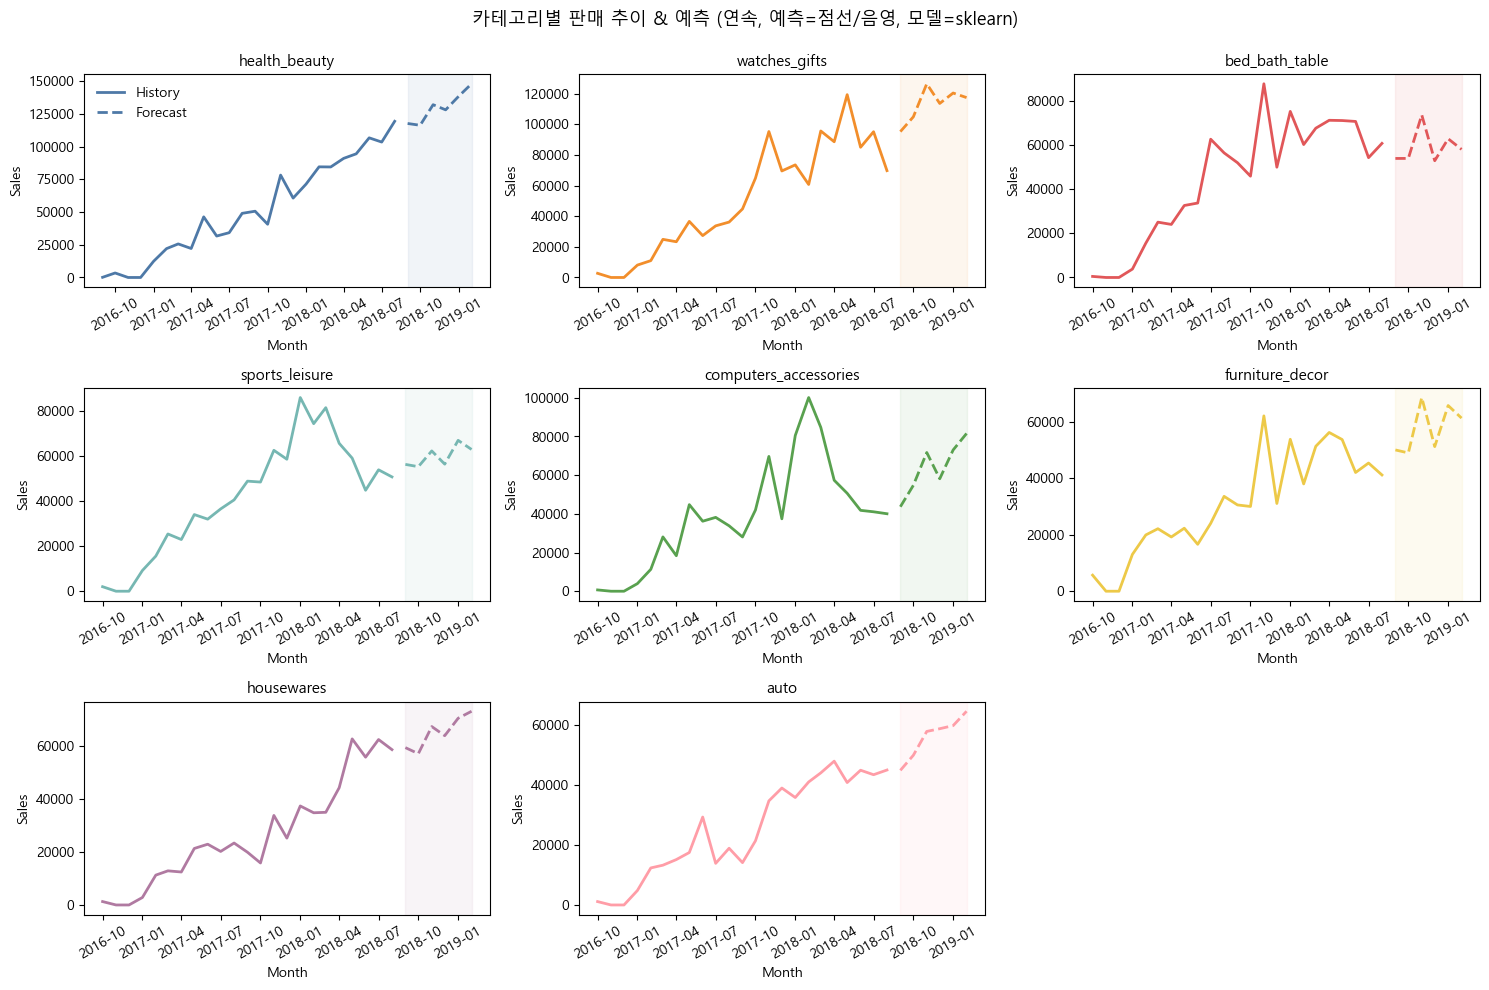

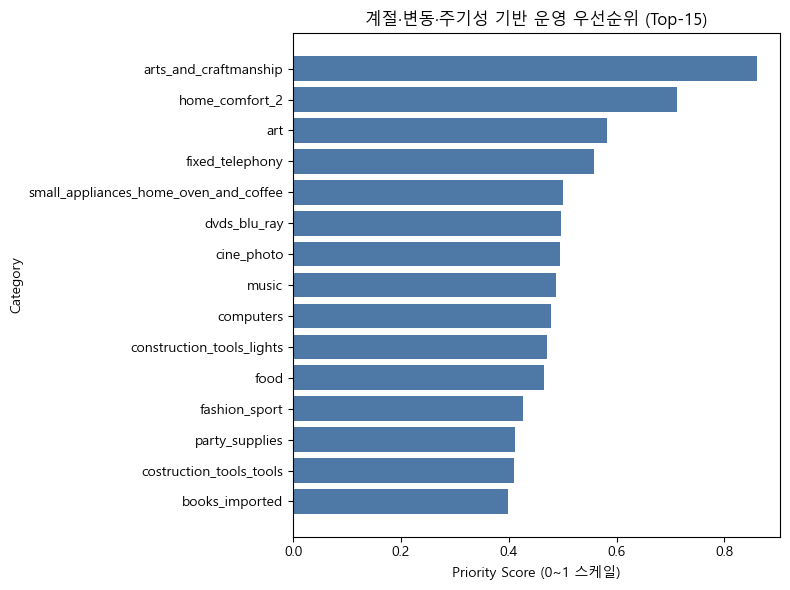

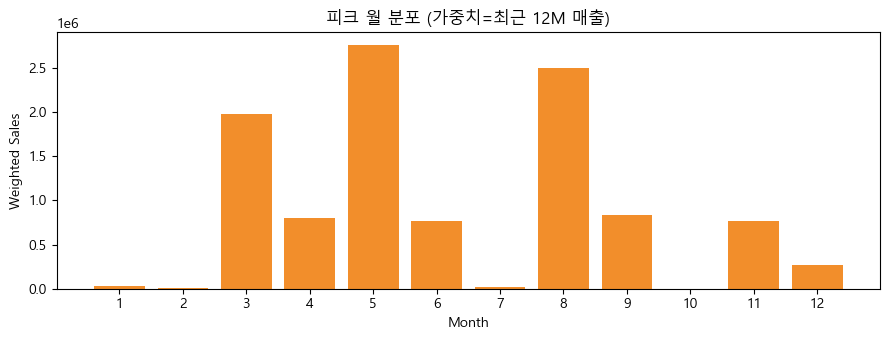

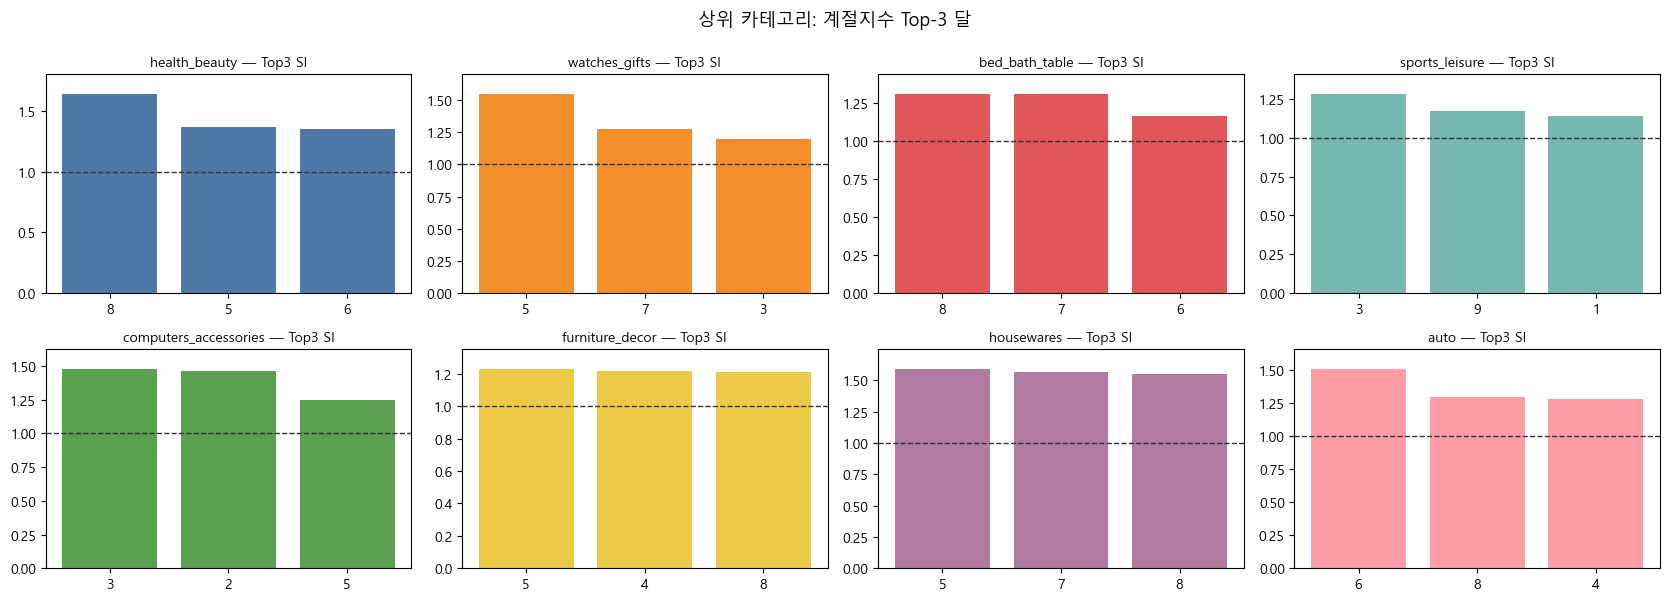

=== 재고전략 표(상위 카테고리, z=1.65) ===


,Category,월평균수요,월표준편차,평균리드타임(일),안전재고,재주문점(ROP)
43,health_beauty,79620.46,24166.20,12.0,25196.69,56989.34
71,watches_gifts,76807.62,22813.56,12.7,24456.14,56877.09
15,computers_accessories,54403.91,22453.23,13.2,24598.29,48581.90
7,bed_bath_table,63468.58,11895.19,12.8,12823.58,39917.19
65,sports_leisure,59749.30,14089.76,12.1,14794.56,38991.59
49,housewares,39248.84,16375.31,10.9,16303.28,30593.20
39,furniture_decor,43767.27,10883.04,12.9,11766.18,30557.30
5,auto,36270.27,11061.25,12.2,11651.23,26432.71


✅ 완료: 연속 예측(점선/음영), sklearn 호환, 대체 시각화, 재고전략 표


In [7]:
# =========================================================
# 카테고리 트렌드/계절성/예측 시각화 - 호환/개선 통합본
# - 예측선: 히스토리=실선, 예측=점선+옅은 음영 (연속 표시)
# - 예측 엔진: baseline(계절지수×추세) vs scikit-learn(Ridge) 토글
# - OHE 호환 패치: sparse_output / sparse 자동 대응
# - 대체 시각화: 운영 우선순위 막대, 피크월 분포, Top-3 시즌달
# - 재고전략 표: 안전재고, ROP
# 전제 DF: orders_clean, order_items_clean, products_clean, category_tr_clean
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 가드 ----------
_need = {"orders_clean","order_items_clean","products_clean","category_tr_clean"}
_missing = [x for x in _need if x not in globals()]
if _missing:
    raise NameError(f"다음 DF가 필요합니다: {_missing}")

# ---------- 카테고리 영문명 보장 ----------
if "category_en" not in products_clean.columns:
    cat_map = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
    products_clean = products_clean.copy()
    products_clean["category_en"] = products_clean["product_category_name"].map(cat_map).fillna("unknown")

# ---------- 월별 집계(없으면 생성) ----------
def _build_cat_monthly_full():
    od = orders_clean.loc[orders_clean["order_status"]=="delivered",
                          ["order_id","order_purchase_timestamp"]].dropna()
    od["order_month"] = od["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

    oi = order_items_clean[["order_id","product_id","price"]].copy()
    prod = products_clean[["product_id","category_en"]].copy()
    oi = oi.merge(prod, on="product_id", how="left")
    oi["category_en"] = oi["category_en"].fillna("unknown")

    od_oi = od.merge(oi, on="order_id", how="inner")
    cat_monthly = (od_oi.groupby(["category_en","order_month"])
                     .agg(sales=("price","sum"),
                          items=("product_id","count"),
                          orders=("order_id","nunique"))
                     .reset_index())

    # 결측월 0 채움
    def _complete_months(df_cat):
        idx = pd.date_range(df_cat["order_month"].min(), df_cat["order_month"].max(), freq="MS")
        out = df_cat.set_index("order_month").reindex(idx)
        out.index.name = "order_month"
        return out.reset_index()

    filled = []
    for cat, g in cat_monthly.groupby("category_en", sort=False):
        gg = _complete_months(g)
        gg["category_en"] = cat
        for col in ["sales","items","orders"]:
            gg[col] = gg[col].fillna(0.0)
        filled.append(gg)
    return pd.concat(filled, ignore_index=True)

if "cat_monthly_full" not in globals():
    cat_monthly_full = _build_cat_monthly_full()

# ---------- 계절지수 & 보조지표 ----------
def seasonal_index_by_moy(series: pd.Series) -> np.ndarray:
    """월별 계절지수(1~12월) 12개를 항상 반환(결측월=1.0)."""
    s = series.asfreq("MS", fill_value=0.0)
    moy = s.groupby(s.index.month).mean()
    overall = moy.mean()
    if overall == 0 or pd.isna(overall): 
        return np.ones(12, dtype=float)
    si = (moy/overall).reindex(range(1,13)).fillna(1.0).to_numpy(float)
    if si.size != 12:  # 방어
        out = np.ones(12, dtype=float); out[:min(12,si.size)] = si[:min(12,si.size)]
        return out
    return si

def acf_at_lag(series: pd.Series, lag=12):
    x = series.asfreq("MS", fill_value=0.0).to_numpy(float)
    if len(x) <= lag or np.allclose(x.std(), 0): 
        return np.nan
    x = x - x.mean()
    return float(np.corrcoef(x[lag:], x[:-lag])[0,1])

# seasonality / summary
si_rows = []
for cat, g in cat_monthly_full.groupby("category_en", sort=False):
    s = g.set_index("order_month")["sales"].asfreq("MS", fill_value=0.0)
    if s.sum()==0 or len(s)<6: 
        continue
    si_vec = seasonal_index_by_moy(s)
    si_rows.append({
        "category_en":cat,
        "seasonal_index":si_vec.tolist(),
        "amp": float(si_vec.max()-si_vec.min()),
        "cv": float(s.std()/s.mean()) if s.mean()>0 else np.nan,
        "acf12": acf_at_lag(s,12),
        "total_sales": float(s.sum())
    })
seasonality = pd.DataFrame(si_rows)
si_cols = [f"SI_{m:02d}" for m in range(1,13)]
if not seasonality.empty:
    seasonality[si_cols] = pd.DataFrame(seasonality["seasonal_index"].tolist(), index=seasonality.index)
    seasonality = seasonality.drop(columns=["seasonal_index"])

if not seasonality.empty:
    amp_norm = seasonality["amp"]/(seasonality["amp"].max() or 1)
    cv_norm  = seasonality["cv"] /(seasonality["cv"].max()  or 1)
    acf_pos  = seasonality["acf12"].clip(lower=0)
    acf_norm = acf_pos/(acf_pos.max() or 1)
    summary = (seasonality.assign(priority_score=0.5*amp_norm+0.3*cv_norm+0.2*acf_norm)
                         .sort_values("priority_score", ascending=False))
else:
    summary = pd.DataFrame(columns=["category_en","amp","cv","acf12","priority_score"])

# ---------- 상위 카테고리 선정(최근 12M) ----------
cutoff_date = cat_monthly_full["order_month"].max()
t12 = cutoff_date - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
top_cats = (cat_monthly_full[cat_monthly_full["order_month"]>=t12]
            .groupby("category_en")["sales"].sum()
            .sort_values(ascending=False).head(8).index.tolist())

# ---------- 예측 엔진: baseline vs scikit-learn ----------
USE_SKLEARN = True  # ← 필요시 False로 바꾸면 baseline 사용

def baseline_forecast_next_6(series: pd.Series) -> pd.Series:
    """최근12M 평균(base) × 성장률(g) × 월별 계절지수로 6M 예측."""
    s = series.asfreq("MS", fill_value=0.0)
    if len(s)<6: 
        return pd.Series(dtype=float)
    end = s.index.max()
    last12  = s.loc[end - pd.DateOffset(months=11): end]
    prev12s = s.loc[end - pd.DateOffset(months=23): end - pd.DateOffset(months=12)]
    base = last12.mean()
    g = (last12.sum()/prev12s.sum())**(1/12)-1 if len(prev12s)==12 and prev12s.sum()>0 else 0.0
    si = seasonal_index_by_moy(s)
    future_idx = pd.date_range(end + pd.DateOffset(months=1), periods=6, freq="MS")
    vals = [ base*((1+g)**i)*float(si[dt.month-1]) for i,dt in enumerate(future_idx,1) ]
    return pd.Series(vals, index=future_idx)

# --- OHE 호환 생성기 (sparse_output / sparse 자동 처리) ---
def _make_ohe_dense():
    from sklearn.preprocessing import OneHotEncoder
    try:
        # 최신 버전(>=1.2)
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # 구버전(<=1.1)
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def sklearn_forecast_next_6(series: pd.Series, alpha=1.0) -> pd.Series:
    """월 더미 + 추세 + 랙(1,2)로 Ridge 예측(6M). scikit-learn 없으면 baseline으로 폴백."""
    try:
        from sklearn.pipeline import Pipeline
        from sklearn.compose import ColumnTransformer
        from sklearn.preprocessing import StandardScaler
        from sklearn.linear_model import Ridge
    except Exception:
        return baseline_forecast_next_6(series)

    s = series.asfreq("MS", fill_value=0.0)
    df = pd.DataFrame({"y": s.values}, index=s.index)
    df["t"] = np.arange(len(df))
    df["month"] = df.index.month
    df["lag1"] = df["y"].shift(1)
    df["lag2"] = df["y"].shift(2)
    train = df.dropna()
    if len(train) < 12:
        return baseline_forecast_next_6(series)

    X = train[["t","month","lag1","lag2"]]; y = train["y"]
    ohe = _make_ohe_dense()
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler
    ct = ColumnTransformer([
        ("mon", ohe, ["month"]),
        ("num", StandardScaler(), ["t","lag1","lag2"])
    ], remainder="drop")

    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import Ridge
    model = Pipeline([("prep", ct), ("ridge", Ridge(alpha=alpha))])
    model.fit(X, y)

    # 6개월 재귀 예측
    future_idx = pd.date_range(s.index[-1] + pd.DateOffset(months=1), periods=6, freq="MS")
    lag1 = df["y"].iloc[-1]
    lag2 = df["y"].iloc[-2] if len(df) >= 2 else lag1
    preds = []
    for i, dt in enumerate(future_idx, 1):
        row = pd.DataFrame([{
            "t": int(df["t"].iloc[-1]) + i,
            "month": dt.month,
            "lag1": lag1,
            "lag2": lag2
        }])
        yf = float(model.predict(row)[0])
        preds.append(yf)
        lag2, lag1 = lag1, yf  # 랙 업데이트
    return pd.Series(preds, index=future_idx)

def forecast_next_6(series: pd.Series) -> pd.Series:
    return sklearn_forecast_next_6(series) if USE_SKLEARN else baseline_forecast_next_6(series)

# ---------- 모든 카테고리 예측 DF ----------
fc_rows = []
for cat, g in cat_monthly_full.groupby("category_en", sort=False):
    s = g.set_index("order_month")["sales"]
    fc = forecast_next_6(s)
    for dt, val in fc.items():
        fc_rows.append({"category_en":cat, "order_month":dt, "forecast_sales":float(val)})
forecast_df = pd.DataFrame(fc_rows)

# ---------- 팔레트 ----------
colors = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
          "#EDC948","#B07AA1","#FF9DA7","#9C755F","#2E7C9E"]

# =========================================================
# (A) 카테고리별 판매 추이 & 예측 — 서브플롯(연속: 실선/점선 + 음영)
# =========================================================
plot_cats = top_cats
n = len(plot_cats)
if n>0:
    cols = 3; rows = (n+cols-1)//cols
    fig = plt.figure(figsize=(5*cols, 3.3*rows))
    for i, cat in enumerate(plot_cats, 1):
        ax = fig.add_subplot(rows, cols, i)
        g = cat_monthly_full[cat_monthly_full["category_en"]==cat]
        s = g.set_index("order_month")["sales"].asfreq("MS", fill_value=0.0)

        # 최근 24M 표시
        start = max(s.index.min(), s.index.max()-pd.DateOffset(months=24)+pd.offsets.MonthBegin(0))
        hist = s.loc[start:]

        # 예측
        fc = forecast_df[forecast_df["category_en"]==cat].set_index("order_month")["forecast_sales"]

        c = colors[(i-1)%len(colors)]
        # 히스토리: 실선
        ax.plot(hist.index, hist.values, color=c, linewidth=2, label="History")
        # 예측: 점선 + 음영
        if not fc.empty:
            ax.plot(fc.index, fc.values, color=c, linewidth=2, linestyle="--", label="Forecast")
            ax.axvspan(fc.index.min(), fc.index.max(), color=c, alpha=0.08)

        ax.set_title(cat, fontsize=11)
        ax.set_xlabel("Month"); ax.set_ylabel("Sales")
        ax.tick_params(axis="x", labelrotation=30)
        if i==1:
            ax.legend(frameon=False, loc="upper left")
    fig.suptitle(f"카테고리별 판매 추이 & 예측 (연속, 예측=점선/음영, 모델={'sklearn' if USE_SKLEARN else 'baseline'})",
                 y=0.995, fontsize=13)
    fig.tight_layout(); plt.show()

# =========================================================
# (B) 운영 우선순위 막대차트 (시즌 강도맵 대체)
# =========================================================
if not summary.empty:
    topN = summary.head(15).sort_values("priority_score")
    plt.figure(figsize=(8,6))
    plt.barh(topN["category_en"], topN["priority_score"], color=colors[0])
    plt.xlabel("Priority Score (0~1 스케일)"); plt.ylabel("Category")
    plt.title("계절·변동·주기성 기반 운영 우선순위 (Top-15)")
    plt.tight_layout(); plt.show()

# =========================================================
# (C) 피크월 분포(가중치=최근 12M 매출)
# =========================================================
if not seasonality.empty:
    si_mat = seasonality.set_index("category_en")[si_cols]
    peak_month = si_mat.apply(lambda r: int(np.argmax(r.values))+1, axis=1)
    weights = (cat_monthly_full[cat_monthly_full["order_month"]>=t12]
               .groupby("category_en")["sales"].sum())
    peak_df = pd.DataFrame({"peak_month":peak_month}).merge(
        weights.rename("w"), left_index=True, right_index=True, how="left").fillna(0)
    weight_by_month = peak_df.groupby("peak_month")["w"].sum().reindex(range(1,13)).fillna(0)

    plt.figure(figsize=(9,3.5))
    plt.bar(range(1,13), weight_by_month.values, color=colors[1])
    plt.title("피크 월 분포 (가중치=최근 12M 매출)")
    plt.xlabel("Month"); plt.ylabel("Weighted Sales")
    plt.xticks(range(1,13))
    plt.tight_layout(); plt.show()

# =========================================================
# (D) 상위 카테고리 Top-3 시즌 달 (미니 바차트)
# =========================================================
if not seasonality.empty and len(top_cats)>0:
    cols = 4; rows = (len(top_cats)+cols-1)//cols
    fig = plt.figure(figsize=(4.2*cols, 3*rows))
    for i, cat in enumerate(top_cats, 1):
        ax = fig.add_subplot(rows, cols, i)
        row = seasonality.loc[seasonality["category_en"]==cat]
        if row.empty:
            ax.set_axis_off(); continue
        si_vals = row[si_cols].iloc[0].values
        top3_idx = np.argsort(si_vals)[-3:][::-1]
        months = [int(m+1) for m in top3_idx]
        vals = si_vals[top3_idx]
        ax.bar([str(m) for m in months], vals, color=colors[(i-1)%len(colors)])
        ax.axhline(1.0, linestyle="--", color="#333333", linewidth=1)
        ax.set_title(f"{cat} — Top3 SI", fontsize=10)
        ax.set_ylim(0, max(1.2, vals.max()*1.1))
    fig.suptitle("상위 카테고리: 계절지수 Top-3 달", y=0.995, fontsize=13)
    fig.tight_layout(); plt.show()

# =========================================================
# (E) 재고관리 전략 표: 안전재고/ROP (z=1.65)
# =========================================================
z = 1.65  # 95% 서비스 레벨
o = orders_clean.loc[orders_clean["order_status"]=="delivered",
                     ["order_id","order_purchase_timestamp","order_delivered_customer_date"]].dropna()
o["lead_days"] = (o["order_delivered_customer_date"] - o["order_purchase_timestamp"]).dt.total_seconds()/86400

oi = order_items_clean[["order_id","product_id"]].copy()
prod = products_clean[["product_id","category_en"]].copy()
oi = oi.merge(prod, on="product_id", how="left").dropna(subset=["category_en"])
oi_o = oi.merge(o[["order_id","lead_days"]], on="order_id", how="inner")
lt_by_cat = oi_o.groupby("category_en")["lead_days"].mean().rename("lead_days_mean")

last12 = (cat_monthly_full[cat_monthly_full["order_month"]>=t12]
          .groupby(["category_en","order_month"])["sales"].sum().reset_index())
mu_sigma = (last12.groupby("category_en")["sales"]
                 .agg(mu_month="mean", sigma_month="std").fillna(0.0))

inv = (mu_sigma.merge(lt_by_cat, left_index=True, right_index=True, how="left")
               .fillna({"lead_days_mean":7.0}))
inv["mu_daily"]    = inv["mu_month"]/30.0
inv["sigma_daily"] = inv["sigma_month"]/np.sqrt(30.0)
inv["safety_stock"] = (z * inv["sigma_daily"] * np.sqrt(inv["lead_days_mean"])).clip(lower=0)
inv["ROP"]          = (inv["mu_daily"] * inv["lead_days_mean"] + inv["safety_stock"]).clip(lower=0)

inv_out = inv.reset_index().rename(columns={
    "category_en":"Category",
    "mu_month":"월평균수요","sigma_month":"월표준편차",
    "lead_days_mean":"평균리드타임(일)","mu_daily":"일평균수요",
    "sigma_daily":"일표준편차","safety_stock":"안전재고","ROP":"재주문점(ROP)"
})
inv_out[["월평균수요","월표준편차","일평균수요","일표준편차","안전재고","재주문점(ROP)"]] = \
    inv_out[["월평균수요","월표준편차","일평균수요","일표준편차","안전재고","재주문점(ROP)"]].round(2)
inv_out["평균리드타임(일)"] = inv_out["평균리드타임(일)"].round(1)

focus = inv_out[inv_out["Category"].isin(top_cats)].sort_values("재주문점(ROP)", ascending=False)
print("=== 재고전략 표(상위 카테고리, z=1.65) ===")
display(focus[["Category","월평균수요","월표준편차","평균리드타임(일)","안전재고","재주문점(ROP)"]])

print("✅ 완료: 연속 예측(점선/음영), sklearn 호환, 대체 시각화, 재고전략 표")



,category_en,month,SI,LT_days,mu_daily_adj,sigma_daily_adj,safety_stock_adj,ROP_adj
0,auto,2018-09-01,0.572,12.2,691.13,1526.89,8809.21,17259.06
1,auto,2018-10-01,0.456,12.2,551.56,1364.03,7869.58,14612.95
2,auto,2018-11-01,0.703,12.2,849.72,1693.03,9767.73,20156.45
3,auto,2018-12-01,0.789,12.2,954.50,1794.39,10352.47,22022.26
4,auto,2019-01-01,0.823,12.2,994.98,1832.05,10569.75,22734.53
5,auto,2019-02-01,1.081,12.2,1306.44,2099.29,12111.58,28084.22
6,auto,2019-03-01,1.160,12.2,1403.00,2175.49,12551.22,29704.48
7,auto,2019-04-01,1.277,12.2,1544.48,2282.55,13168.87,32051.92
8,auto,2019-05-01,1.181,12.2,1427.41,2194.34,12659.92,30111.60
9,auto,2019-06-01,1.503,12.2,1817.47,2476.06,14285.33,36505.89


month,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01
category_en,,,,,,,,,,,,
auto,17259.06,14612.95,20156.45,22022.26,22734.53,28084.22,29704.48,32051.92,30111.60,36505.89,29703.97,32380.97
bed_bath_table,45329.34,23287.68,39292.06,24724.65,36000.46,34758.97,41140.48,42095.27,45232.91,45494.85,50089.27,50191.24
computers_accessories,38681.18,31783.47,45365.14,28967.56,52363.66,64698.63,65295.64,48262.16,57433.07,49341.84,49927.65,47382.65
furniture_decor,30252.52,19779.80,30644.11,17775.22,32526.93,28978.01,35127.99,35899.17,36129.12,29270.31,33546.74,35640.04
health_beauty,33424.87,30169.10,46207.60,38139.64,48667.64,58659.09,60161.71,61474.18,73085.96,72069.52,71795.99,84364.21


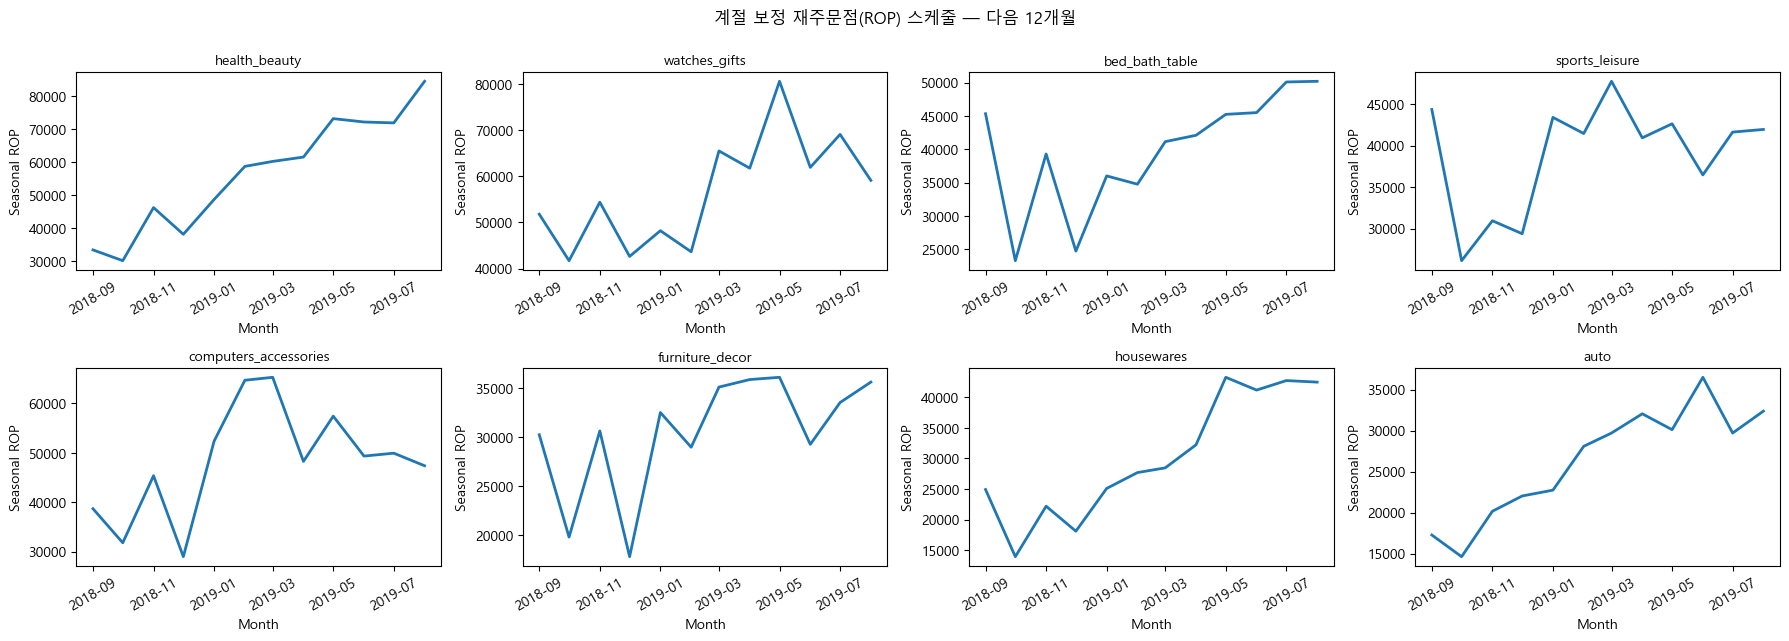

In [8]:
# =========================================================
# [계절 보정 ROP] 피크 달에 재주문점 더 크게 잡기
# - ROP_m = (μ_daily * SI_m) * LT  +  z * (σ_daily * (SI_m**0.5 if 옵션)) * sqrt(LT)
# - 출력: seasonal_rop(롱포맷), seasonal_rop_pivot(카테고리×월 피벗)
# 전제: seasonality(SI_01~SI_12), cat_monthly_full, top_cats,
#      orders_clean, order_items_clean, products_clean 가 메모리에 존재
# =========================================================

# 0) 파라미터
z = 1.65  # 95% 서비스 레벨
HORIZON = 12  # 예측/스케줄 개월 수
ADJUST_SIGMA_WITH_SQRT_SI = True  # σ를 √SI로 스케일링하여 보수적으로 계산

# 1) 카테고리별 평균 리드타임(일) & 최근 12M 월수요 통계 확보
if 'inv' not in globals():
    o = orders_clean.loc[orders_clean["order_status"]=="delivered",
                         ["order_id","order_purchase_timestamp","order_delivered_customer_date"]].dropna()
    o["lead_days"] = (o["order_delivered_customer_date"] - o["order_purchase_timestamp"]).dt.total_seconds()/86400

    oi = order_items_clean[["order_id","product_id"]].copy()
    prod = products_clean[["product_id","category_en"]].copy()
    oi = oi.merge(prod, on="product_id", how="left").dropna(subset=["category_en"])
    oi_o = oi.merge(o[["order_id","lead_days"]], on="order_id", how="inner")
    lt_by_cat = oi_o.groupby("category_en")["lead_days"].mean().rename("lead_days_mean")

    cutoff_date = cat_monthly_full["order_month"].max()
    t12 = cutoff_date - pd.DateOffset(months=12) + pd.offsets.MonthBegin(0)
    last12 = (cat_monthly_full[cat_monthly_full["order_month"]>=t12]
              .groupby(["category_en","order_month"])["sales"].sum().reset_index())
    mu_sigma = (last12.groupby("category_en")["sales"]
                     .agg(mu_month="mean", sigma_month="std").fillna(0.0))

    inv = (mu_sigma.merge(lt_by_cat, left_index=True, right_index=True, how="left")
                   .fillna({"lead_days_mean":7.0}))
    inv["mu_daily"]    = inv["mu_month"]   / 30.0
    inv["sigma_daily"] = inv["sigma_month"] / np.sqrt(30.0)

# 2) SI 딕셔너리 준비 (카테고리 → {1..12: SI})
si_cols = [c for c in seasonality.columns if c.startswith("SI_")]
def _si_dict(row):
    d = {}
    for m in range(1,13):
        d[m] = float(row[f"SI_{m:02d}"])
    return d
si_map = {r["category_en"]:_si_dict(r) for _, r in seasonality[["category_en"]+si_cols].iterrows()}

# 3) 향후 12개월 인덱스
last_month = cat_monthly_full["order_month"].max()
future_months = pd.date_range(last_month + pd.DateOffset(months=1), periods=HORIZON, freq="MS")

# 4) 계절 보정 ROP 스케줄 계산 (상위 카테고리 중심)
rows = []
cats = top_cats if 'top_cats' in globals() and len(top_cats)>0 else inv.index.tolist()
for cat in cats:
    if cat not in si_map or cat not in inv.index:  # 필수 정보 없으면 스킵
        continue
    LT = float(inv.loc[cat, "lead_days_mean"])
    mu_d = float(inv.loc[cat, "mu_daily"])
    sigma_d = float(inv.loc[cat, "sigma_daily"])
    for dt in future_months:
        m = dt.month
        SI = float(si_map[cat][m])
        mu_adj = mu_d * SI
        if ADJUST_SIGMA_WITH_SQRT_SI:
            sigma_adj = sigma_d * (SI ** 0.5)
        else:
            sigma_adj = sigma_d
        safety = z * sigma_adj * np.sqrt(LT)
        rop    = mu_adj * LT + safety
        rows.append({
            "category_en": cat,
            "month": dt,
            "SI": round(SI, 3),
            "LT_days": round(LT, 1),
            "mu_daily_adj": round(mu_adj, 2),
            "sigma_daily_adj": round(sigma_adj, 2),
            "safety_stock_adj": round(safety, 2),
            "ROP_adj": round(rop, 2)
        })

seasonal_rop = pd.DataFrame(rows).sort_values(["category_en","month"]).reset_index(drop=True)

# 5) 보기 좋은 피벗(카테고리 × 월 → ROP)
seasonal_rop_pivot = seasonal_rop.pivot(index="category_en", columns="month", values="ROP_adj")
display(seasonal_rop.head(12))
display(seasonal_rop_pivot.head())

# 6) 간단 선그래프: 상위 카테고리의 월별 ROP 스케줄
plot_cats = cats[:8]
if len(plot_cats)>0:
    cols = 4
    rows = (len(plot_cats)+cols-1)//cols
    plt.figure(figsize=(4.5*cols, 3.2*rows))
    for i, cat in enumerate(plot_cats, 1):
        ax = plt.subplot(rows, cols, i)
        g = seasonal_rop[seasonal_rop["category_en"]==cat]
        ax.plot(g["month"], g["ROP_adj"], linewidth=2)
        ax.set_title(cat, fontsize=10)
        ax.set_xlabel("Month"); ax.set_ylabel("Seasonal ROP")
        ax.tick_params(axis="x", labelrotation=30)
    plt.suptitle(f"계절 보정 재주문점(ROP) 스케줄 — 다음 {HORIZON}개월", y=0.995)
    plt.tight_layout(); plt.show()


실선은 지금까지의 판매량, 점선은 앞으로 6개월 예상이에요. 음영은 예상 구간이에요.

막대가 길수록 더 중요하거나 더 많이 팔리는 달/카테고리예요.

표의 안전재고와 **재주문점(ROP)**은 “품절 안 나게 보관해야 하는 최소 수량”이라고 기억하면 돼요.

1) 카테고리별 판매 추이 & 예측 (서브플롯)

실선 = 지난달들 판매량, 점선 = 다음 6개월 예상, 옅은 색 영역 = 예측 구간.

선이 오르막이면 점점 더 잘 팔린다는 뜻이에요(예: health_beauty).

점선이 실선의 끝과 자연스럽게 이어져 앞으로도 비슷한 흐름을 보일 거라고 알려줘요.

이 그림으로 “언제 많이 팔릴지”를 미리 보고 행사/광고/입고 시기를 정할 수 있어요.

2) 운영 우선순위 막대차트 (Top-15)

막대가 길수록 계절성(달마다 차이) + 흔들림 + 반복 패턴이 커서 관리의 중요도가 높아요.

위쪽에 있는 카테고리는 먼저 신경 써야 할 과목 같은 거예요.

이런 과목들은 수요 변동이 커서 재고가 모자라거나 남기 쉽기 때문에 계획을 더 꼼꼼히 세워야 해요.

쉽게 말해, **막대가 길수록 “우선 챙겨!”**라고 생각하면 돼요.

3) 피크 월 분포 (가중치=최근 12개월 매출)

1~12월 중 어느 달에 전체적으로 가장 많이 팔리는지 보여줘요.

막대가 높은 달(예: 5월, 8월)은 많이 팔리는 달 → 미리 더 준비해야 해요.

이 달들 앞에 입고를 빨리 하고, 광고/쿠폰도 집중하면 좋아요.

반대로 낮은 달은 재고를 줄이고 소규모 행사로 평균을 맞추면 좋아요.

4) 상위 카테고리 Top-3 시즌 달 (미니 바차트)

각 인기 카테고리마다 특히 잘 팔리는 3개월만 뽑아서 보여줘요.

예: health_beauty는 8·5·6월, watches_gifts는 5·7·3월, sports_leisure는 3·9·1월에 강해요.

막대가 1.0보다 높으면 평균보다 더 많이 팔리는 달이에요(1.2면 +20%).

이 달들은 골든 타임이니, 행사·입고·배송 인력을 그때에 맞춰 늘리면 좋아요.

5) 재고전략 표(상위 카테고리)

월평균수요: 한 달에 보통 이만큼 팔려요.

평균리드타임(일): 주문해서 창고에 오기까지 걸리는 기다리는 시간이에요.

안전재고: 갑자기 주문이 많아져도 품절이 안 나게 쌓아두는 보너스 재고예요.

재주문점(ROP): 창고 재고가 이 숫자보다 적어지면 바로 주문해야 해요(“신호등의 노란불”).

예: health_beauty

안전재고 ≈ 25,197개, ROP ≈ 56,989개 → 재고가 이 수치 아래로 내려가기 전에 미리 발주!

한 줄 가이드(정리)

**언제 많이 팔릴지(점선·음영)**를 보고 미리 준비하세요.

막대가 긴 카테고리는 우선 관리, 피크 달엔 추가 발주를!

표의 ROP/안전재고는 품절을 막는 최소선—그 아래로 떨어지기 전에 주문하면 됩니다.

안전재고: 예상보다 주문이 몰리거나 배송이 늦어도 버틸 수 있게 해주는 비상 창고량.

재주문점(ROP): 창고 재고(재고포지션)가 여기에 닿는 순간 발주 버튼을 누른다.

수식(우리가 코드에서 쓴 것):

ROP = (일평균수요 × 리드타임일수) + 안전재고

안전재고 = z × 일표준편차 × √(리드타임일수)

(계절 보정 시 일평균수요와 일표준편차에 월별 SI 적용)

포인트: 안전재고는 ROP에 포함돼요. 그래서 보통 ROP > 안전재고가 됩니다.
즉, ROP는 “언제 주문할지”를 알려주는 경계선, 안전재고는 “최후의 방어선”이에요.


재고포지션(On-hand + On-order − Backorder)이 ROP 이하로 내려가면 발주.

**피크월(계절성↑)**에는 ROP를 더 크게(계절지수, 변동성 반영) → 우리가 방금 코드로 만든 Seasonal ROP가 그거예요.

서비스레벨 z(예: 95% → 1.65)를 올리면 안전재고가 커지고, 품절 위험은 줄지만 보관비가 늘어요.